# Weather --> CNN --> LSTM --> Streamflow

# Preamble

In [1]:
#check memory available for use

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 26.4 GB  | Proc size: 156.6 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [2]:
#first: are you working in colab?
colab = 1

if colab:
    
    #mount drive
    from google.colab import drive
    drive.mount('/content/drive')
    
    #define path to google drive data
    dataPath = '/content/drive/My Drive/Colab Notebooks/T_P_F_pca_lstm/'

    #download required libraries that are not already in colab
    !pip install geopandas
    !pip install minisom
    
else:
    
    dataPath = ''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#import required libraries

import pandas as pd
import numpy as np
#from netCDF4 import Dataset
%tensorflow_version 2.x
import tensorflow
import tensorflow.keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, LSTM, Flatten, TimeDistributed, Dropout, Input
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model, Sequential, regularizers
import pickle
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.cluster import KMeans
from scipy import interpolate
import time
import seaborn as sns
import time

TensorFlow 2.x selected.


In [0]:
prov = 'AB'

if prov == 'BC':
  flowpickle = 'BCActNat30_flowvars.pickle'
elif prov == 'AB':
  flowpickle = 'flowDict.pickle'

In [0]:
#define functions that we'll use

def nse(y_obs, y_model):

  """
  NSE = nse(y_obs, y_model)

  y_obs, y_model --> these are arrays of the same length (1 x N or N x1) where N is the number of observations in time
  """

  y_model = y_model.reshape((-1,1))
  y_obs = y_obs.reshape((-1,1))
  nse = 1 - np.sum((y_model - y_obs)**2) / np.sum((y_obs - np.mean(y_obs))**2)
  return nse

def nse_rolling(y_obs, y_model, window, stride = 1):

  """
  NSE_rolling = nse_rolling(y_obs, y_model, window, stride)

  y_obs, y_model --> these are arrays of the same length (1 x N or N x 1) where N is the number of observations in time
  window --> this is the length of time over which to compute NSE, which will roll accross the total time period
  stride --> default stride = 1; length of step to take when rolling (i.e. stride = 365 computes yearly NSE with no overlap)
  """

  NSE_rolling = []

  y_model = y_model.reshape((-1,1))
  y_obs = y_obs.reshape((-1,1))

  startInds = range(0, len(y_model) - window, stride)
  for startInd in startInds:
    y_model_window = y_model[startInd:startInd+window] 
    y_obs_window = y_obs[startInd:startInd+window]
    NSE = nse(y_obs_window, y_model_window)
    NSE_rolling.append(NSE)

  return NSE_rolling

def plot_AB(prov='AB'):

    """
    plot borders of alberta
    
    example:
    import geopandas as gpd
    import matplotlib.pyplot as plt
    plot_AB()
    plt.show()
    """
    
    provIndex=0
    provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/PROVINCE.SHP'
    provshapes = gpd.read_file(provshapes_filename)
    provPoly = provshapes['geometry'][provIndex]
    lonBorder,latBorder = provPoly.exterior.coords.xy 

    plt.plot(lonBorder,latBorder,'k')

def rmse(target,prediction):
  """ RMSE = rmse(target,prediction) """

  return(np.sqrt(((target.reshape(-1,1) - prediction.reshape(-1,1))**2).sum()/len(target.reshape(-1,1))))

def rmse_group(*args):
  rmse_group = []
  for arg in args:
    for other_arg in args:
      rmse_group.append(rmse(arg,other_arg))

  rmse_group = np.mean(rmse_group)

  return rmse_group

# Load data and preprocess

In [0]:
#load data

pickle_in = open(dataPath + flowpickle,'rb')
flowDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'tempDict_ERA5.pickle','rb')
tempDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'precDict_ERA5.pickle','rb')
precDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'spcHDict_ERA5.pickle','rb')
spcHDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'ssrdDict_ERA5.pickle','rb')
ssrdDict = pickle.load(pickle_in)

In [0]:
#unpack data

stationLat = flowDict['stationLat']
stationLon = flowDict['stationLon']
eraLat = tempDict['latERA']
eraLon = tempDict['lonERA']

flowDays = flowDict['windowDays']
flowMonths = flowDict['windowMonths']
flowYears = flowDict['windowYears']
eraDays = tempDict['daysERA']
eraMonths = tempDict['monthsERA']
eraYears = tempDict['yearsERA']

F = flowDict['all_flowwindow_norm_NF'] #normalized discharge with nans filled (NF)
T = tempDict['T']
Tmax = tempDict['Tmax']
Tmin = tempDict['Tmin']
P = precDict['P']
H = spcHDict['H']
S = ssrdDict['S']

x_lat = np.empty((len(eraLat),len(eraLon)))
kk = 0
for lat in eraLat:
    x_lat[kk,:] = lat
    kk+=1
    
x_lon = np.empty((len(eraLat),len(eraLon)))
kk = 0
for lon in eraLon:
    x_lon[:,kk] = lon
    kk+=1

In [0]:
del tempDict, precDict, spcHDict, ssrdDict

In [0]:
#set nan values to mean values of field (ie: out of province values

meanT = np.nanmean(T)
meanTmax = np.nanmean(Tmax)
meanTmin = np.nanmean(Tmin)
meanP = np.nanmean(P)
meanH = np.nanmean(H)
meanS = np.nanmean(S)

Tall = np.copy(T)
Tall[np.where(np.isnan(Tall))] = np.nanmean(T)
T = Tall

Tmaxall = np.copy(Tmax)
Tmaxall[np.where(np.isnan(Tmaxall))] = np.nanmean(Tmax)
Tmax = Tmaxall

Tminall = np.copy(Tmin)
Tminall[np.where(np.isnan(Tminall))] = np.nanmean(Tmin)
Tmin = Tminall

Pall = np.copy(P)
Pall[np.where(np.isnan(Pall))] = np.nanmean(P)
P = Pall

Hall = np.copy(H)
Hall[np.where(np.isnan(Hall))] = np.nanmean(H)
H = Hall

Sall = np.copy(S)
Sall[np.where(np.isnan(Sall))] = np.nanmean(S)
S = Sall

x_lat_all = np.copy(x_lat)
x_lat_all[np.where(np.isnan(x_lat_all))] = np.nanmean(x_lat)
x_lat = x_lat_all

x_lon_all = np.copy(x_lon)
x_lon_all[np.where(np.isnan(x_lon_all))] = np.nanmean(x_lon)
x_lon = x_lon_all

In [0]:
#select subset of stations?

customStations = 1

if customStations:

  stationInds = np.array([18,19,34,35,59,60,61,64,69,102,103,104,106,107,127,150,163,176]) - 1
  stationInds = np.array([1,2,3,9,13,26,27,41,49,62,68,76,77,78,86,120,130,131,132,134,167,18,19,34,35,59,60,61,64,69,102,103,104,106,107,127,150,163,176])-1 #these are the stations with a record > 90 years, mean flow > 1 m^3/s
  stationInds = np.array([2,13,27,41,62,78,86,120,131,132,134,167,19,35,59,60,61,64,102,103,106,107,127,150,163,176]) - 1 #these are the stations with a record > 90 years, mean flow > 1 m^3/s, fewest nans
  stationInds = np.array([2,13,27,62,86,120,132,134,167,19,35,59,60,64,102,103,106,107,127,150,163,176]) - 1 #these are the stations with a record > 90 years, mean flow > 1 m^3/s, fewest nans, and don't have a min flow close to zero
  stationInds = np.array([19,35,59,60,64,102,103,106,107,127,163,176]) - 1 #these are the stations with a record > 90 years, mean flow > 1 m^3/s, fewest nans, and don't have a min flow close to zero
  
  #stationInds = np.asarray([1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,17,25,28,29,30,32,46,49,50,51,52,54,55,56,57,58,77,82,83,84,85,89,90,91,92,93,94,95,194]) - 1 #these are flashy prairie -- does ERA 5 do well?
  #stationInds = np.asarray([1,2,3,4,5,6,9,13,28,29,30,49,77]) - 1 #these are flashy prairie -- does ERA 5 do well?
  
  #stationInds = np.array([2,9,13,26,27,29,31,36,42,43,45,50,54,56,58,77,80,81,84,85,93,94,97,101,102,109,112,122,130,131,141,143,160,210,216]) - 1 #BC
  #stationInds = np.array([2,9,13,26,27,29,31,36,42,43,45,50,54,56,58,77,80,81,84,85,93,94,97,101,102,109,112,122,130,131,141,143,160,210,216, 61, 71, 72, 203]) - 1 #BC with rainy stations
  
  F = np.asarray(F)
  F = np.transpose(np.squeeze(F[stationInds]))

else:

  stationInds = np.arange(0,194,1)
  F = np.asarray(np.transpose(np.squeeze(F[indStartFlow:])))

In [0]:
#make data have same time range
startYear = max(int(np.min(eraYears)),int(np.min(flowYears)))
finYear = min(int(np.max(eraYears)),int(np.max(flowYears)))

indStartERA = min(np.argwhere(eraYears==startYear))[0]
indStartFlow = min(np.argwhere(flowYears==startYear))[0]

indFinERA = max(np.argwhere(eraYears==finYear))[0]
indFinFlow = max(np.argwhere(flowYears==finYear))[0]

F = F[indStartFlow:indFinFlow]
T = np.asarray(T[indStartERA:indFinERA])
Tmax = np.asarray(Tmax[indStartERA:indFinERA])
Tmin = np.asarray(Tmin[indStartERA:indFinERA])
P = np.asarray(P[indStartERA:indFinERA])
H = np.asarray(H[indStartERA:indFinERA])
S = np.asarray(S[indStartERA:indFinERA])

flowDays = flowDays[indStartFlow:indFinFlow]
flowMonths = flowMonths[indStartFlow:indFinFlow]
flowYears = flowYears[indStartFlow:indFinFlow]

eraDays = eraDays[indStartERA:indFinERA]
eraMonths = eraMonths[indStartERA:indFinERA]
eraYears = eraYears[indStartERA:indFinERA]

In [0]:
#loop through stations and find the closest era grid cell

stationT = np.empty((len(stationLat),len(eraDays)))
stationTmax = np.empty((len(stationLat),len(eraDays)))
stationTmin = np.empty((len(stationLat),len(eraDays)))
stationP = np.empty((len(stationLat),len(eraDays)))
stationH = np.empty((len(stationLat),len(eraDays)))
stationS = np.empty((len(stationLat),len(eraDays)))
#stationM = np.empty((len(stationLat),len(eraDays)))

for kk in range(len(stationLat)): #for each station
    
    dlat = np.min(np.abs(stationLat[kk] - eraLat))
    indLat = np.argwhere(np.abs(stationLat[kk] - eraLat) == dlat)[0]
    dlon = np.min(np.abs(stationLon[kk] - eraLon))
    indLon = np.argwhere(np.abs(stationLon[kk] - eraLon) == dlon)[0]
    
    stationT[kk] = np.squeeze(T[:,indLat,indLon])
    stationTmax[kk] = np.squeeze(Tmax[:,indLat,indLon])
    stationTmin[kk] = np.squeeze(Tmin[:,indLat,indLon])
    stationP[kk] = np.squeeze(P[:,indLat,indLon])
    stationH[kk] = np.squeeze(H[:,indLat,indLon])
    stationS[kk] = np.squeeze(S[:,indLat,indLon])
    #stationM[kk] = np.squeeze(M[kk])

#stationsWithGlaciers = np.squeeze(np.argwhere(np.sum(stationM,axis=1)>0))

#normalize
meanT = np.mean(stationT)
meanTmax = np.mean(stationTmax)
meanTmin = np.mean(stationTmin)
meanP = np.mean(stationP)
meanH = np.mean(stationH)
meanS = np.mean(stationS)
#meanM = np.mean(stationM)

stdT = np.std(stationT)
stdTmax = np.std(stationTmax)
stdTmin = np.std(stationTmin)
stdP = np.std(stationP)
stdH = np.std(stationH)
stdS = np.std(stationS)
#stdM = np.std(stationM)

stationT = (stationT - meanT)/stdT
stationTmax = (stationTmax - meanTmax)/stdTmax
stationTmin = (stationTmin - meanTmin)/stdTmin
stationP = (stationP - meanP)/stdP
stationH = (stationH - meanH)/stdH
stationS = (stationS - meanS)/stdS
#stationM = (stationM - meanM)/stdM

In [0]:
#reduce spatial extent to only bound the stations of interest (reduce memory requirements)

minLon = np.min(stationLon[stationInds])
maxLon = np.max(stationLon[stationInds])
minLat = np.min(stationLat[stationInds])
maxLat = np.max(stationLat[stationInds])

indMinLonERA = np.argmin(np.abs(eraLon - minLon))
indMaxLonERA = np.argmin(np.abs(eraLon - maxLon))
indMinLatERA = np.argmin(np.abs(eraLat - minLat))
indMaxLatERA = np.argmin(np.abs(eraLat - maxLat))

T = T[:, indMaxLatERA:indMinLatERA, indMinLonERA:indMaxLonERA]
Tmax = Tmax[:, indMaxLatERA:indMinLatERA, indMinLonERA:indMaxLonERA]
Tmin = Tmin[:, indMaxLatERA:indMinLatERA, indMinLonERA:indMaxLonERA]
P = P[:, indMaxLatERA:indMinLatERA, indMinLonERA:indMaxLonERA]
H = H[:, indMaxLatERA:indMinLatERA, indMinLonERA:indMaxLonERA]
S = S[:, indMaxLatERA:indMinLatERA, indMinLonERA:indMaxLonERA]
x_lat = x_lat[indMaxLatERA:indMinLatERA, indMinLonERA:indMaxLonERA] * np.ones(np.shape(T))
x_lon = x_lon[indMaxLatERA:indMinLatERA, indMinLonERA:indMaxLonERA] * np.ones(np.shape(T))

In [14]:
print(np.shape(F),np.shape(T),np.shape(P),np.shape(H),np.shape(S),np.shape(x_lat),np.shape(x_lon))

(8765, 12) (8765, 18, 24) (8765, 18, 24) (8765, 18, 24) (8765, 18, 24) (8765, 18, 24) (8765, 18, 24)


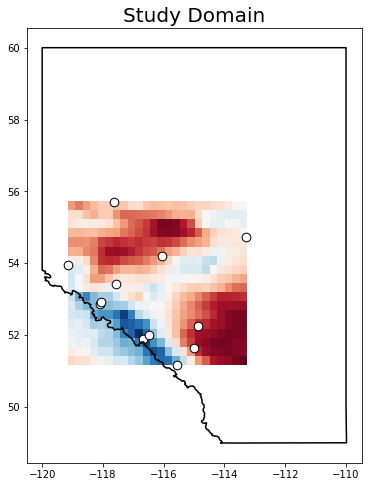

In [15]:
extentERA = [minLon,maxLon,minLat,maxLat]

plt.figure(figsize = (6,8))
plot_AB()
plt.imshow(T[0],aspect='auto',extent = extentERA, cmap = 'RdBu_r')
plt.scatter(stationLon[stationInds],stationLat[stationInds], facecolor = 'w', edgecolor = 'k', s = 75)
plt.title('Study Domain',fontsize = 20)

plt.show()

In [0]:
#prep data: standardize

#indices of testing/training
trainStartYear = 1987
trainFinYear = 2005
testStartYear = 2006
testFinYear = 2010

trainInds = np.squeeze(np.argwhere((flowYears>=trainStartYear) & (flowYears<=trainFinYear)))
testInds = np.squeeze(np.argwhere((flowYears>=testStartYear) & (flowYears<=testFinYear)))

#standardize variables individually (normalize wrt training period), then save as 32-bit rather than 64-bit for space
Tmean_train = np.mean([T[trainInds[ii]] for ii in range(len(trainInds))])
Tstd_train = np.std([T[trainInds[ii]] for ii in range(len(trainInds))])
Tnorm = (T - Tmean_train)/Tstd_train
Tnorm = np.single(Tnorm)

Tmaxmean_train = np.mean([Tmax[trainInds[ii]] for ii in range(len(trainInds))])
Tmaxstd_train = np.std([Tmax[trainInds[ii]] for ii in range(len(trainInds))])
Tmaxnorm = (Tmax - Tmaxmean_train)/Tmaxstd_train
Tmaxnorm = np.single(Tmaxnorm)

Tminmean_train = np.mean([Tmin[trainInds[ii]] for ii in range(len(trainInds))])
Tminstd_train = np.std([Tmin[trainInds[ii]] for ii in range(len(trainInds))])
Tminnorm = (Tmin - Tminmean_train)/Tminstd_train
Tminnorm = np.single(Tnorm)

Pmean_train = np.mean([P[trainInds[ii]] for ii in range(len(trainInds))])
Pstd_train = np.std([P[trainInds[ii]] for ii in range(len(trainInds))])
Pnorm = (P - Pmean_train)/Pstd_train
Pnorm = np.single(Pnorm)

Hmean_train = np.mean([H[trainInds[ii]] for ii in range(len(trainInds))])
Hstd_train = np.std([H[trainInds[ii]] for ii in range(len(trainInds))])
Hnorm = (H - Hmean_train)/Hstd_train
Hnorm = np.single(Hnorm)

Smean_train = np.mean([S[trainInds[ii]] for ii in range(len(trainInds))])
Sstd_train = np.std([S[trainInds[ii]] for ii in range(len(trainInds))])
Snorm = (S - Smean_train)/Sstd_train
Snorm = np.single(Snorm)

x_lat_mean_train = np.mean([x_lat[trainInds[ii]] for ii in range(len(trainInds))])
x_lat_std_train = np.std([x_lat[trainInds[ii]] for ii in range(len(trainInds))])
x_lat_norm = (x_lat - x_lat_mean_train)/x_lat_std_train
x_lat_norm = np.single(x_lat_norm)

x_lon_mean_train = np.mean([x_lon[trainInds[ii]] for ii in range(len(trainInds))])
x_lon_std_train = np.std([x_lon[trainInds[ii]] for ii in range(len(trainInds))])
x_lon_norm = (x_lon - x_lon_mean_train)/x_lon_std_train
x_lon_norm = np.single(x_lon_norm)

##Fmean_train = np.nanmean([F[ii][trainInds[366:]] for ii in range(len(F))])
##Fstd_train = np.nanstd([F[ii][trainInds[366:]] for ii in range(len(F))])
#Fmean_train = np.mean(F[trainInds[366:],:])
#Fstd_train = np.std(F[trainInds[366:],:])
#Fnorm = (F - Fmean_train)/Fstd_train
#Fnorm = np.single(Fnorm)

In [0]:
#normalize flow

Fnorm = np.empty_like(F)
for station in range(np.shape(F)[1]):
    #F[:,station] = (F[:,station] - np.mean(F[:,station]))/np.std(F[:,station])
    minF = np.min(F[:,station])
    maxF = 2 * np.std(F[:,station])
    Fnorm[:,station] = (F[:,station] - minF) / (maxF - minF)
    
for inds in np.argwhere(Fnorm>4):
  Fnorm[inds[0],inds[1]] = 4

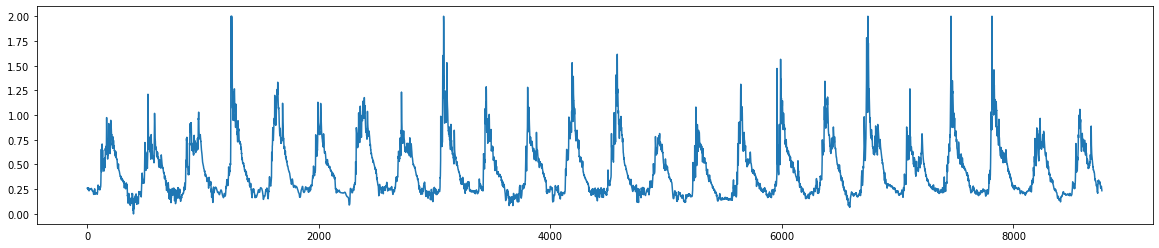

In [18]:
plt.figure(figsize = (20,4))
plt.plot(np.sqrt(Fnorm[:,1]))
plt.show()

(array([6.805e+03, 1.384e+03, 3.610e+02, 1.320e+02, 4.500e+01, 1.300e+01,
        9.000e+00, 5.000e+00, 2.000e+00, 9.000e+00]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

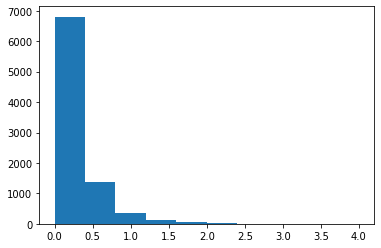

In [19]:

plt.hist(np.power(Fnorm[:,1],1))

In [0]:
#construct train and test predictor/target tensors

#target data
#y_train = np.squeeze([Fnorm[366:len(trainInds)+366,ii] for ii in range(np.shape(Fnorm)[1])])
#y_test = np.squeeze([Fnorm[testInds[1:],ii] for ii in range(np.shape(Fnorm)[1])])
#target data
y_train = np.squeeze([Fnorm[365:trainInds[-1]+1,ii] for ii in range(np.shape(F)[1])]).T
y_test = np.squeeze([Fnorm[testInds,ii] for ii in range(np.shape(F)[1])]).T
y = np.empty((len(y_train[:,0])+len(y_test[:,0]),np.shape(F)[1])).T
y[:,:len(y_train[:,0])] = y_train.T
y[:,len(y_train[:,0]):] = y_test.T
y = y.T

#y_test = np.power(y_test,1/3)
#y_train = np.power(y_train,1/3)
#y = np.power(y,1/3)

stationP = stationP.T
y_transfer_train = np.squeeze([stationP[365:trainInds[-1]+1,ii] for ii in range(np.shape(F)[1])]).T
y_transfer_test = np.squeeze([stationP[testInds,ii] for ii in range(np.shape(F)[1])]).T
#y_transfer = np.empty((len(y_train[:,0])+len(y_test[:,0]),np.shape(F)[1])).T

#first, make (n_time x n_lon x n_lat x n_vars) tensor 
#x_intermediate = np.zeros((8766,17,43,2))
nchannels = 5
x_intermediate = np.empty(np.shape(Tmaxnorm) + (nchannels,),dtype=np.float16)#'single')
x_intermediate[:,:,:,0] = Tmaxnorm
x_intermediate[:,:,:,1] = Tminnorm
x_intermediate[:,:,:,2] = Pnorm
#x_intermediate[:,:,:,3] = Hnorm
#x_intermediate[:,:,:,4] = Snorm
x_intermediate[:,:,:,3] = x_lat_norm
x_intermediate[:,:,:,4] = x_lon_norm
x_train_intermediate = x_intermediate[trainInds]
x_test_intermediate = x_intermediate[testInds]

In [0]:
#now, convert x_intermediate into (n_time x 365 x n_lon x n_lat x n_vars) tensor
#x = np.zeros((8765-365,365,45,41,5),dtype='single')
x_train = np.empty((len(trainInds)-365, 365, ) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)
x_test = np.empty((len(testInds), 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)

In [0]:
for ii in range(1000):
    x_train[ii] = x_intermediate[ii:ii+365]

In [0]:
for ii in range(1000,2000):
    x_train[ii] = x_intermediate[ii:ii+365]

In [0]:
for ii in range(2000,3000):
    x_train[ii] = x_intermediate[ii:ii+365]

In [0]:
for ii in range(3000,4000):
    x_train[ii] = x_intermediate[ii:ii+365]

In [0]:
for ii in range(4000,len(trainInds)-365):
    x_train[ii] = x_intermediate[ii:ii+365]

In [0]:
for ii in range(1000):
    x_test[ii] = x_intermediate[ii+len(trainInds)-365:ii+len(trainInds)]

In [0]:
for ii in range(1000,len(testInds)):
    x_test[ii] = x_intermediate[ii+len(trainInds)-365:ii+len(trainInds)]

In [29]:
#CNN model
print('Building model...')

learning_rate = 0.0001

model = Sequential()

model.add(TimeDistributed(
    Conv2D(filters = 8, kernel_size = (3,3), activation='relu',data_format='channels_last', padding='same'), 
    input_shape=(365,)+np.shape(Tnorm[0])+(nchannels,)))

model.add(TimeDistributed(
    Conv2D(filters = 8, kernel_size = (3,3), activation='relu',data_format='channels_last', padding='same'), 
    input_shape=(365,)+np.shape(Tnorm[0])+(nchannels,)))

model.add(TimeDistributed(MaxPooling2D(pool_size = 2)))

model.add(TimeDistributed(
    Conv2D(filters = 16, kernel_size = (2,2), activation='relu',data_format='channels_last', padding='same'), 
    ))

model.add(TimeDistributed(
    Conv2D(filters = 16, kernel_size = (2,2), activation='relu',data_format='channels_last', padding='same'), 
    ))

model.add(TimeDistributed(MaxPooling2D(pool_size = 2)))

#model.add(TimeDistributed(
#    Conv2D(filters = 32, kernel_size = (2,2), activation='relu',data_format='channels_last', padding='same'), 
#    ))
#
#model.add(TimeDistributed(
#    Conv2D(filters = 32, kernel_size = (2,2), activation='relu',data_format='channels_last', padding='same'), 
#    ))

#model.add(TimeDistributed(MaxPooling2D(pool_size = 2)))

model.add(TimeDistributed(Flatten()))

model.add(Dropout(rate = 0.2))

#LSTM model with time-distributed CNN as input
#model.add(LSTM(units = 40, activation='tanh', recurrent_activation='hard_sigmoid', 
#               use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', 
#               bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, 
#               recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
#               kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, implementation=1, 
#               return_sequences=True, return_state=False))
#model.add(LSTM(units = 40, activation='tanh', recurrent_activation='hard_sigmoid', 
#               use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', 
#               bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, 
#               recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
#               kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, implementation=1, 
#               return_sequences=False, return_state=False))
#model.add(Dense(194, activation = 'relu'))

model.add(LSTM(40, return_sequences=True))
model.add(Dropout(rate=0.2))
#model.add(LSTM(20, return_sequences=True))
#model.add(Dropout(rate=0.1))

model.add(Flatten())
model.add(Dense(np.shape(Fnorm)[1], activation = 'linear'))

#compile
print('Compiling model...')
model.compile(loss=tensorflow.keras.losses.MSE,
              optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate),
              )

es = EarlyStopping(monitor='val_loss', 
                   mode = 'min',
                   verbose = 1, 
                   patience = 3,
                   restore_best_weights = True)

model.summary()

Building model...
Compiling model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 365, 18, 24, 8)    368       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 365, 18, 24, 8)    584       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 365, 9, 12, 8)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 365, 9, 12, 16)    528       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 365, 9, 12, 16)    1040      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 365, 4, 6, 16)     0         
_________________________________________________________________
time_distributed_6 

In [30]:
np.shape(x_train), np.shape(y_train), np.shape(x_test), np.shape(y_test), np.shape(y_transfer_train), np.shape(y_transfer_test)

((6575, 365, 18, 24, 5),
 (6575, 12),
 (1825, 365, 18, 24, 5),
 (1825, 12),
 (6575, 12),
 (1825, 12))

In [0]:
#train model: transfer problem

transferModel = 0

batch_size = 128
epochs = 40

if transferModel == 1:

  print('Compiling model...')
  model.compile(loss=tensorflow.keras.losses.MSE,
              optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate/10),
              )

  history = model.fit(x_train,y_transfer_train, 
                      validation_split = 0.2,
                      shuffle = True, 
                      epochs = epochs, 
                      batch_size = batch_size,
                      verbose = 1, 
                      callbacks = [es])

In [0]:
#plot loss

if transferModel:

  saveIt = 0

  if trainModel:

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(loss, 'y', label='Training')
    plt.plot(val_loss, 'r', label='Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    #plt.xlim((1,10))
    #plt.ylim((0,.1))
    #plt.show()

    if saveIt:
      plt.savefig('loss.png')

In [33]:
#train model

trainModel = 1

batch_size = 128
epochs = 40

if trainModel == 1:

  print('Compiling model...')
  model.compile(loss=tensorflow.keras.losses.MSE,
              optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate),
              )

  history = model.fit(x_train,y_train, 
                      validation_split = 0.2,
                      shuffle = True, 
                      epochs = epochs, 
                      batch_size = batch_size,
                      verbose = 1, 
                      callbacks = [es])

Compiling model...
Train on 5260 samples, validate on 1315 samples
Epoch 1/40
5260/5260 [==============================] - 25s 5ms/sample - loss: 0.0803 - val_loss: 0.0505
Epoch 2/40
5260/5260 [==============================] - 14s 3ms/sample - loss: 0.0422 - val_loss: 0.0444
Epoch 3/40
5260/5260 [==============================] - 14s 3ms/sample - loss: 0.0367 - val_loss: 0.0422
Epoch 4/40
5260/5260 [==============================] - 14s 3ms/sample - loss: 0.0340 - val_loss: 0.0404
Epoch 5/40
5260/5260 [==============================] - 14s 3ms/sample - loss: 0.0318 - val_loss: 0.0394
Epoch 6/40
5260/5260 [==============================] - 14s 3ms/sample - loss: 0.0300 - val_loss: 0.0380
Epoch 7/40
5260/5260 [==============================] - 14s 3ms/sample - loss: 0.0281 - val_loss: 0.0376
Epoch 8/40
5260/5260 [==============================] - 14s 3ms/sample - loss: 0.0266 - val_loss: 0.0370
Epoch 9/40
5260/5260 [==============================] - 14s 3ms/sample - loss: 0.0257 - val_l

In [0]:
#save model

saveModel = 0
glacierStations = 0

if saveModel == 1:

  if glacierStations == 1:
    modelName = str(num_stations) + '_stations_' + 'CNN_LSTM_DENSE_glacierStations_' + str(epochs) + '_epochs'
    model.save(modelName + '.h5')
  else:
    modelName = str(num_stations) + '_stations_' + 'CNN_LSTM_DENSE_' + str(epochs) + '_epochs'
    model.save(modelName + '.h5')

In [0]:
#load model

loadModel = 0

if loadModel == 1:

  dataPath = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/'

  if glacierStations == 1:
    modelName = str(num_stations) + '_stations_' + 'CNN_LSTM_DENSE_glacierStations_' + str(epochs) + '_epochs'
    model = load_model(dataPath + modelName + '.h5')
  else:
    modelName = str(num_stations) + '_stations_' + 'CNN_LSTM_DENSE_' + str(epochs) + '_epochs'
    model = load_model(dataPath + modelName + '.h5')

  #model = load_model(dataPath + str(num_stations) + '_stations_LSTM_DO_LSTM_DENSE.h5')

In [0]:
model_bulk = tensorflow.keras.models.clone_model(model)

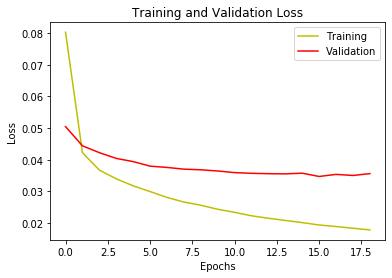

In [34]:
#plot loss

saveIt = 0

if trainModel:

  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  plt.plot(loss, 'y', label='Training')
  plt.plot(val_loss, 'r', label='Validation')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  #plt.xlim((1,10))
  #plt.ylim((0,.1))
  #plt.show()

  if saveIt:
    plt.savefig('loss.png')

In [0]:
trainSmallBatch = 0

if trainSmallBatch:

  #fit
  batch_size = 64
  epochs = 10
  history = model.fit(
              x_train, y_train,
              validation_split = 0.2,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1, 
              callbacks = [es],
            )

In [0]:
freezeWeights = 0

if freezeWeights:

  for layer in model.layers:
    layer.trainable = False
    #print(layer)


In [0]:
addLSTMLayer = 0

if addLSTMLayer:

  #store the post-LSTM layers
  FC= model.layers[-1]
  flat = model.layers[-2]

  #remove post-LSTM layers from model
  model.pop() #remove Dense
  model.pop() #remove flatten
  model.add(LSTM(40, return_sequences=True))
  #model.add(LSTM(20, return_sequences=True))
  #model.add(LSTM(20, return_sequences=True))
  #model.add(Dropout(rate=0.1))

  model.add(flat) 
  model.add(FC) 

  model.compile(loss=tensorflow.keras.losses.MSE,
              optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate))
  
  model.summary()
  


In [0]:
fineTuneLastLayer = 0

if fineTuneLastLayer:
  #fit
  batch_size = 128
  epochs = 20
  history = model.fit(
              x_train, y_train,
              validation_split = 0.2,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1, 
              callbacks = [es],
            )

In [35]:
print('Calculating predicted training values...')
y_train_predicted = model.predict(x_train, batch_size = batch_size, verbose = 1)

print('Calculating predicted testing values...')
y_test_predicted = model.predict(x_test, batch_size = batch_size, verbose = 1)

print('Calculating all predicted values...')
#y_predicted = model.predict(x, batch_size = 256, verbose = 1)
y_predicted = np.vstack((y_train_predicted,y_test_predicted))

Calculating predicted training values...
6575/6575 [==============================] - 8s 1ms/sample
Calculating predicted testing values...
1825/1825 [==============================] - 2s 1ms/sample
Calculating all predicted values...


In [0]:
rescale = 0

if rescale:
  
  y_train_predicted = np.power(y_train_predicted,3)
  y_test_predicted = np.power(y_test_predicted,3)
  y_predicted = np.power(y_predicted,3)

  y_train = np.power(y_train,3)
  y_test = np.power(y_test,3)
  y = np.power(y,3)

IndexError: ignored

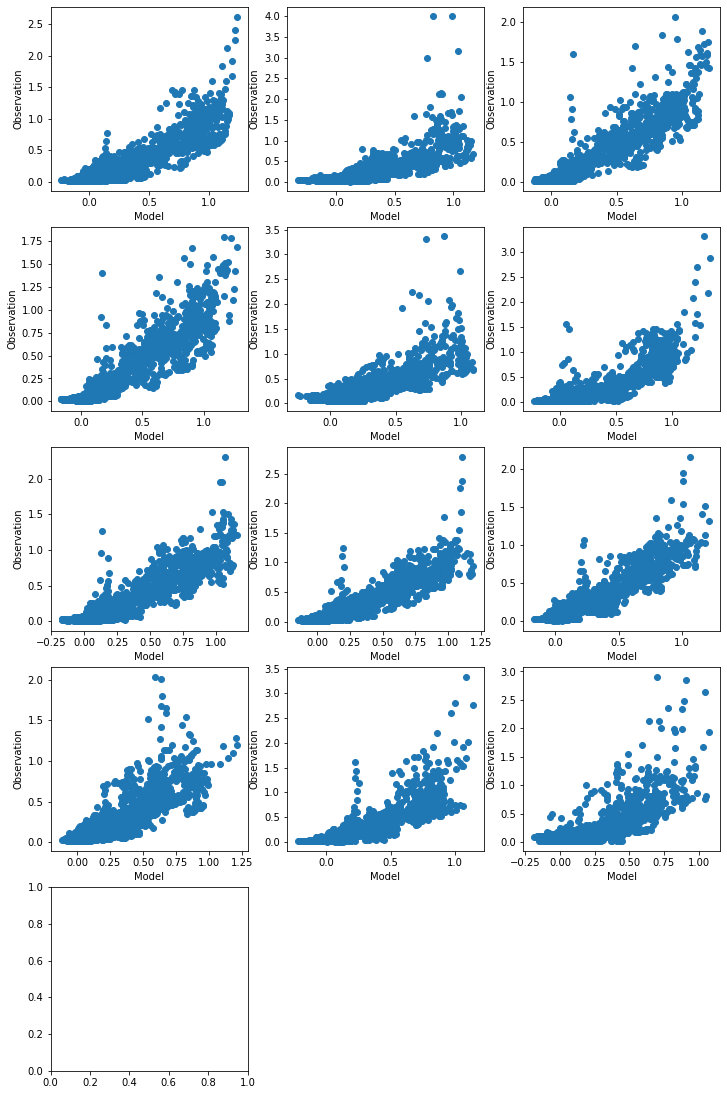

In [45]:
n_target = 40
plt.figure(figsize=(3*4,np.ceil(n_target/3)*4))

for pred in range(n_target):

    plt.subplot(int(np.ceil(n_target/3)),3,pred+1)
    xi = y_test_predicted[:,pred]
    yi = y_test[:,pred]
    plt.scatter(xi,yi)
    plt.xlabel('Model')
    plt.ylabel('Observation')
    #plt.ylim((-0.1,1))

plt.tight_layout()
plt.show()

In [0]:
#check r2 at each station

from sklearn.metrics import r2_score

r2 = np.empty(np.shape(F)[1])
for kk in range(np.shape(F)[1]):
  r2[kk] = r2_score(y_test[:,kk],y_test_predicted[:,kk])

# Investigate Performance in Space and Time

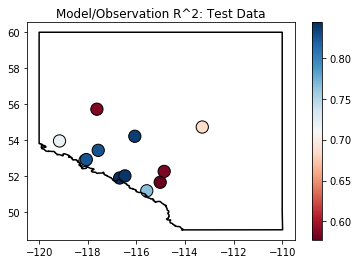

In [47]:
#visualize

#plt.scatter(stationLon[stationInds],stationLat[stationInds],c=r2,cmap='RdBu',vmin = 0, s = 150, edgecolors = 'k')
plt.scatter(stationLon[stationInds],stationLat[stationInds],c=r2,cmap='RdBu', s = 150, edgecolors = 'k')
plot_AB()
plt.title('Model/Observation R^2: Test Data')
plt.colorbar()
plt.show()

In [59]:
dataPath = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/'

#what are the streamflow predictions at each station?

num_stations = len(stationInds)

NSE_station = []
NSE_station_test = []
NSE_rolling_station = []

for station in range(num_stations):
  
  NSE = nse(y[:,station], y_predicted[:,station])
  NSE_station.append(NSE)

  NSE_test = nse(y_test[:,station], y_test_predicted[:,station])
  NSE_station_test.append(NSE_test)

  NSE_rolling = nse_rolling(y[:,station], y_predicted[:,station], window = 366, stride = 365)
  NSE_rolling = np.asarray(NSE_rolling)
  thresh = 0
  indices = NSE_rolling < thresh
  NSE_rolling[indices] = 0
  NSE_rolling_station.append(NSE_rolling)

NSE_rolling_station = np.asarray(NSE_rolling_station).T
#NSE_rolling_station[np.argwhere(NSE_rolling_station<0)] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


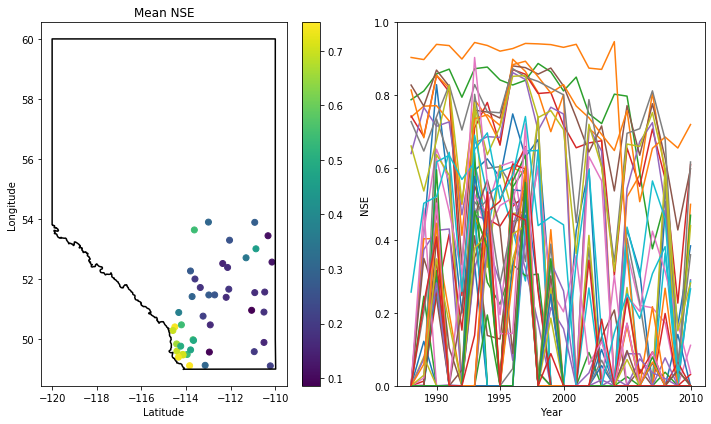

In [60]:
#visualize performance

saveIt = 0

plt.figure(figsize = (10,6))

plt.subplot(1,2,1)
#inds = stationsWithGlaciers[range(num_stations)]
#inds = [val for val in range(num_stations)]
plt.scatter(stationLon[stationInds], stationLat[stationInds], c = NSE_station)
plot_AB()
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Mean NSE')
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(range(1988,2011),NSE_rolling_station)
plt.xlabel('Year')
plt.ylabel('NSE')
plt.ylim((0,1))

plt.tight_layout()

if saveIt == 1:
  plt.savefig('meanNSE_and_series.png')

plt.show()

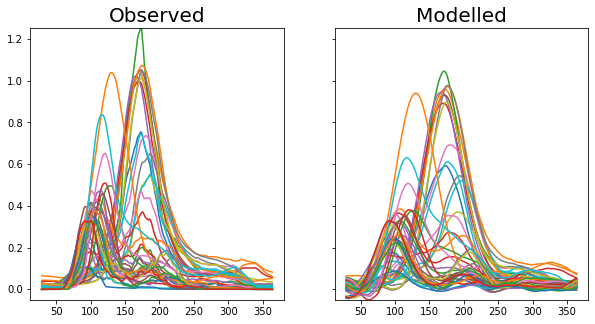

In [61]:
#compute smoothed seasonal over test period
#plan: find leap years, remove last day of SF from leap years, reshape SF at each station into matrix, find average

windowYears = flowDict['windowYears']
trainYears = windowYears[trainInds]
testYears = windowYears[testInds]
windowYears = windowYears[365:]
trainYears = trainYears[365:]

yearsForSOM = windowYears
yForSOM = np.concatenate((np.reshape(y_predicted[0],(1,-1)),np.copy(y_predicted)))
totalYears = yearsForSOM[-1] - yearsForSOM[0]

##the first value in y_test is the second day in testInds
#y_new = np.empty((np.shape(y_test)[0],np.shape(y_test)[1]+1),dtype='single')
#y_new[:,1:] = y_test
#y_new[:,0] = y_new[:,1]

lastDayOfYear = np.argwhere(yearsForSOM[1:] - yearsForSOM[:-1] == 1) + 1
lastDayOfLeapYear = lastDayOfYear[np.argwhere(lastDayOfYear[1:]-lastDayOfYear[:-1] == 366)[:,0]+1]
lastDayOfLeapYear = np.vstack((lastDayOfLeapYear,366))
y_new1 = np.copy(yForSOM)
y_new2 = np.delete(y_new1,lastDayOfLeapYear,axis=0)

y_new3 = np.concatenate((np.reshape(y[0],(1,-1)),np.copy(y)))
y_new4 = np.delete(y_new3, lastDayOfLeapYear, axis = 0)

y_test_seasonal = np.empty((365,np.shape(F)[1]),dtype='single')
y_test_seasonal_smooth = np.empty_like(y_test_seasonal)

y_test_predicted_seasonal = np.empty((365,np.shape(F)[1]),dtype='single')
y_test_predicted_seasonal_smooth = np.empty_like(y_test_predicted_seasonal)

for streamGauge in range(num_stations):
    
    dummy = np.reshape(y_new4[:,streamGauge],(totalYears+1,365))
    y_test_seasonal[:,streamGauge] = np.mean(dummy,axis=0)
    
    x = pd.Series(y_test_seasonal[:,streamGauge])      
    y_test_seasonal_smooth[:,streamGauge] = x.rolling(30).mean()

    dummy = np.reshape(y_new2[:,streamGauge],(totalYears+1,365))
    y_test_predicted_seasonal[:,streamGauge] = np.mean(dummy,axis=0)
    
    x = pd.Series(y_test_predicted_seasonal[:,streamGauge])      
    y_test_predicted_seasonal_smooth[:,streamGauge] = x.rolling(30).mean()


fig, (ax1, ax2) = plt.subplots(1,2,sharey = True,figsize = (10,5))
for ii in range(np.shape(F)[1]):
    #plt.subplot(121)
    ax1.plot(y_test_seasonal_smooth[:,ii])
    ax1.set_ylim((np.nanmin((y_test_seasonal_smooth, y_test_predicted_seasonal_smooth)),np.nanmax((y_test_seasonal_smooth, y_test_predicted_seasonal_smooth))))
    ax1.set_title('Observed',fontsize = 20)

    #plt.subplot(122)
    ax2.plot(y_test_predicted_seasonal_smooth[:,ii])
    ax2.set_ylim((np.nanmin((y_test_seasonal_smooth, y_test_predicted_seasonal_smooth)),np.nanmax((y_test_seasonal_smooth, y_test_predicted_seasonal_smooth))))
    ax2.set_title('Modelled',fontsize = 20)

plt.show()

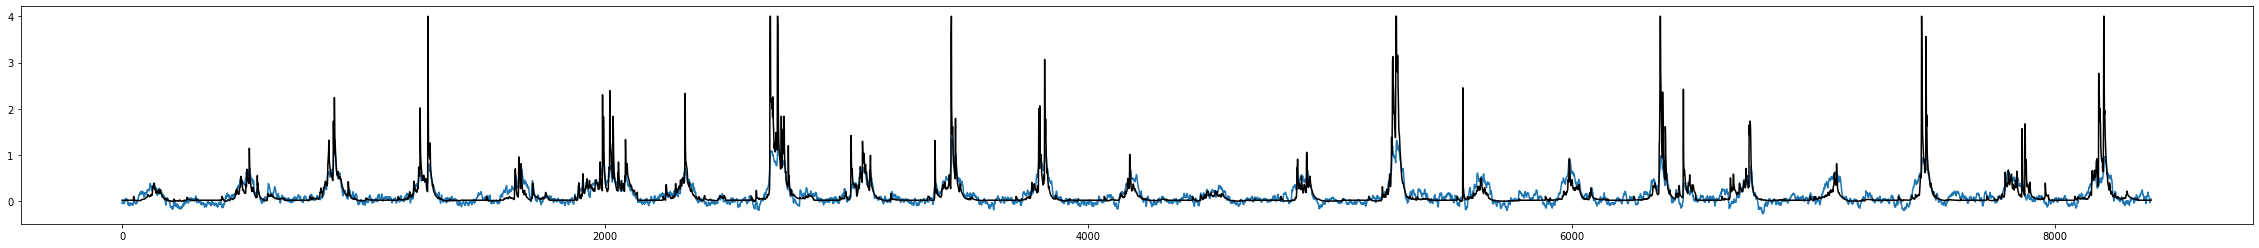

In [62]:
plt.figure(figsize = (40,4))
plt.plot(y_predicted[:,0])
plt.plot(y[:,0],'k')
#plt.ylim((-0.1,3))
#plt.xlim((0,1000))
plt.show()

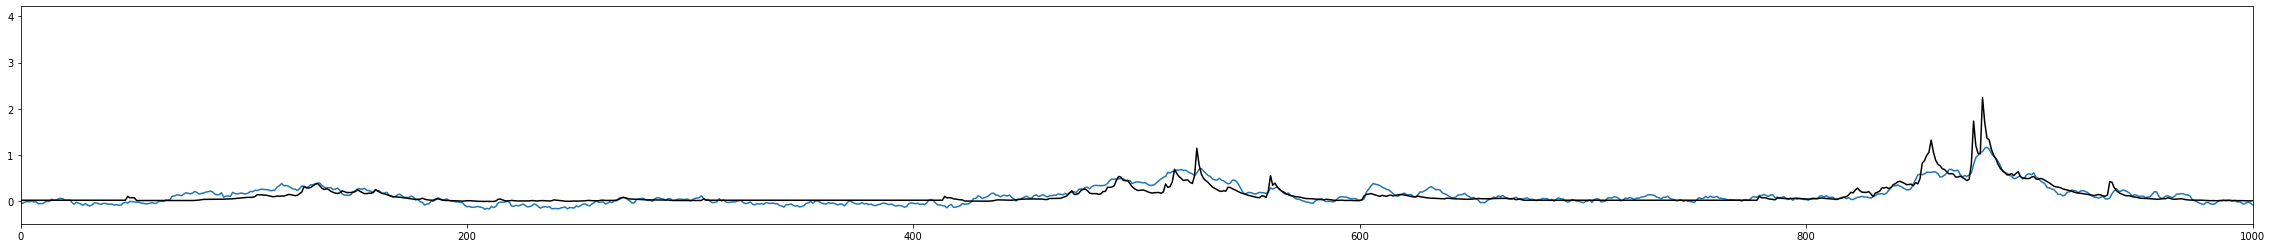

In [63]:
plt.figure(figsize = (40,4))
plt.plot(y_predicted[:,0])
plt.plot(y[:,0],'k')
#plt.ylim((-0.1,3))
plt.xlim((0,1000))
plt.show()

/usr/local/lib/python3.6/dist-packages/minisom.py:304: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]


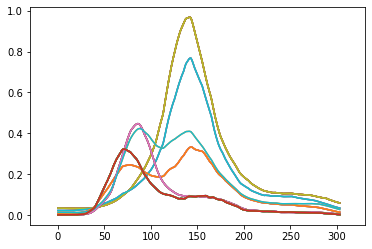

In [64]:

from minisom import MiniSom   
data = y_test_seasonal_smooth[31:-30].T
som = MiniSom(3, 2, 304, sigma=1, learning_rate=0.5) # initialization of 6x6 SOM
som.pca_weights_init(data)
som.train_random(data, 500) # trains the SOM with 100 iterations

qnt = som.quantization(data)

for ii in range(np.shape(F)[1]):
    plt.plot(qnt[ii,:])
    plt.xlim((-30,330))

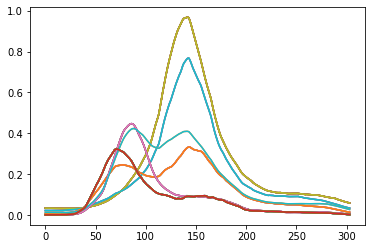

In [65]:
plt.plot(qnt.T)
plt.show()

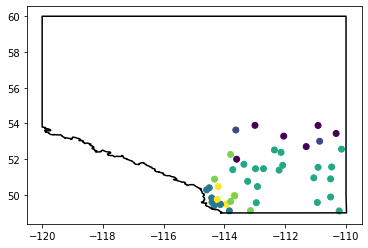

In [66]:
w = []
bmus = []
bmus_ref = [[1,4],[2,5],[3,6]]
for ii in range(np.shape(F)[1]):
    w.append(som.winner(data[ii,:]))
    bmus.append(bmus_ref[w[ii][0]][w[ii][1]])

plot_AB()
plt.scatter(stationLon[stationInds],stationLat[stationInds],c=bmus)

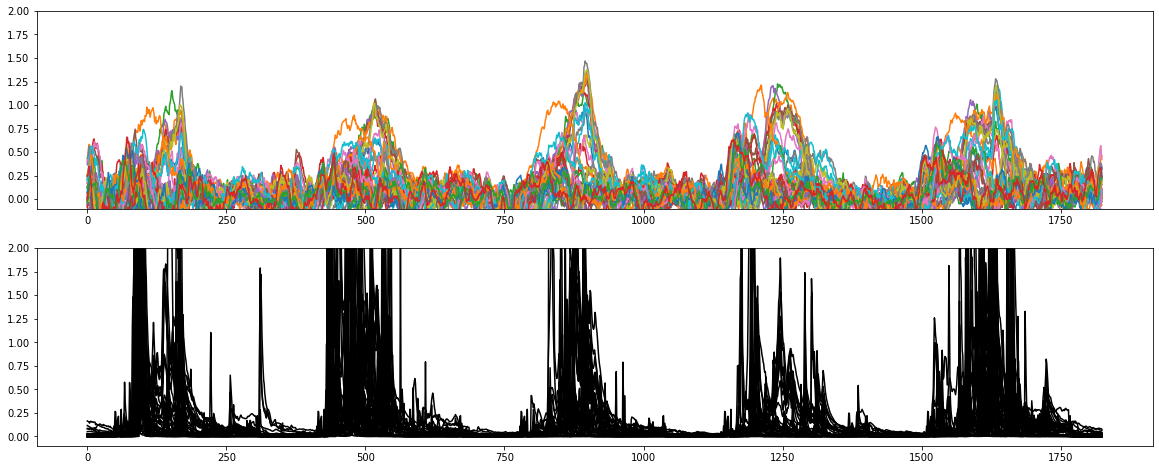

In [67]:
plt.figure(figsize = (20,8))
plt.subplot(211)
plt.plot(y_test_predicted)
plt.ylim((-0.1,2))
#plt.ylim((-1,5))
plt.subplot(212)
plt.plot(y_test,'k')
plt.ylim((-0.1,2))
#plt.ylim((-1,5))
plt.show()

In [0]:
#cluster NSE time series

data = NSE_rolling_station.T

n_clusters = 3
kmeans = KMeans(n_clusters = n_clusters).fit(data)
labels = kmeans.labels_

#find mean pattern of each cluster
cluster_pattern = np.empty((n_clusters,np.shape(data)[1]))
for cluster_num in range(n_clusters):
    inds = np.argwhere(labels==cluster_num)
    cluster_pattern[cluster_num,:] = np.mean(data[inds,:],axis=0)
    
cluster_obs = np.empty((np.shape(data)))
for ind in range(len(data)):
    cluster_obs[ind] = cluster_pattern[labels[ind]]


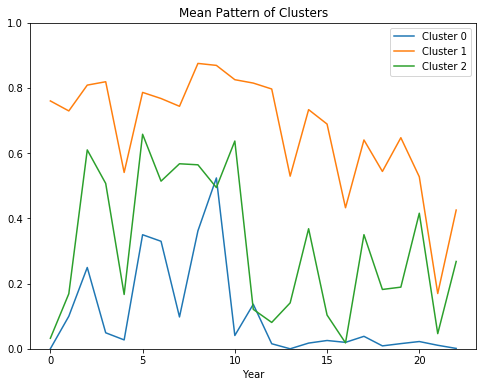

In [69]:
#visualize clusters

plt.figure(figsize = (8,6))

plt.plot(cluster_pattern.T)
plt.xlabel('Year')
plt.title('Mean Pattern of Clusters')
plt.legend(['Cluster ' + str(ii) for ii in range(n_clusters)])
plt.ylim((0,1))
plt.show()

Median Test NSE = -0.0
Median All NSE = 0.28

Max Test NSE = 0.64
Max All NSE = 0.75

Min Test NSE = -1.2
Min All NSE = 0.08


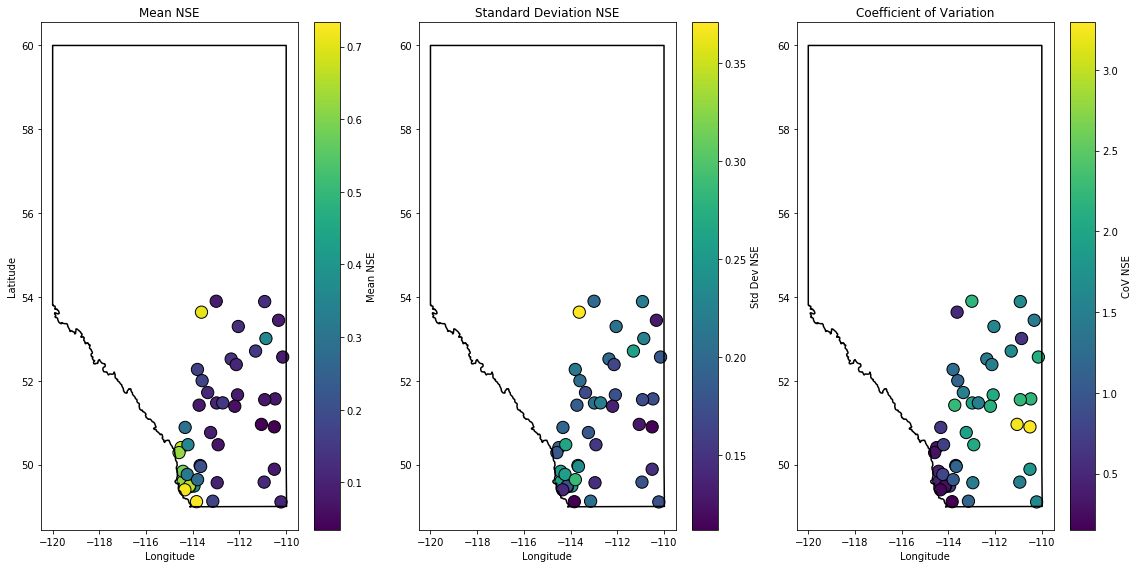

In [70]:
#plot mean NSE and variability of NSE

#inds = stationsWithGlaciers[range(num_stations)]

NSE_mean_stations = np.mean(NSE_rolling_station,axis=0)
NSE_mean_stations_test = np.mean(np.asarray(NSE_rolling_station)[-(testFinYear - testStartYear + 1):,:],axis=0)
NSE_std_stations = np.std(NSE_rolling_station,axis=0)
NSE_cov_stations = NSE_std_stations / NSE_mean_stations

print('Median Test NSE = ' + str(np.median(NSE_station_test))[:4])
print('Median All NSE = ' + str(np.median(NSE_station))[:4])
print('')
print('Max Test NSE = ' + str(np.max(NSE_station_test))[:4])
print('Max All NSE = ' + str(np.max(NSE_station))[:4])
print('')
print('Min Test NSE = ' + str(np.min(NSE_station_test))[:4])
print('Min All NSE = ' + str(np.min(NSE_station))[:4])

plt.figure(figsize = (16,8))

plt.subplot(1,3,1)
plt.scatter(stationLon[stationInds], stationLat[stationInds], c = NSE_mean_stations, s = 150, edgecolors = 'k')
plot_AB()
#plt.scatter(stationLon[inds[-4:]],stationLat[inds[-4:]], marker = 's')
cbar = plt.colorbar()
cbar.set_label('Mean NSE')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Mean NSE')

plt.subplot(1,3,2)
plt.scatter(stationLon[stationInds], stationLat[stationInds], c = NSE_std_stations, s = 150, edgecolors = 'k')
plot_AB()
cbar = plt.colorbar()
cbar.set_label('Std Dev NSE')
plt.xlabel('Longitude')
plt.title('Standard Deviation NSE')

plt.subplot(1,3,3)
plt.scatter(stationLon[stationInds], stationLat[stationInds], c = NSE_cov_stations, s = 150, edgecolors = 'k')
plot_AB()
cbar = plt.colorbar()
cbar.set_label('CoV NSE')
plt.xlabel('Longitude')
plt.title('Coefficient of Variation')

plt.tight_layout()
plt.show()

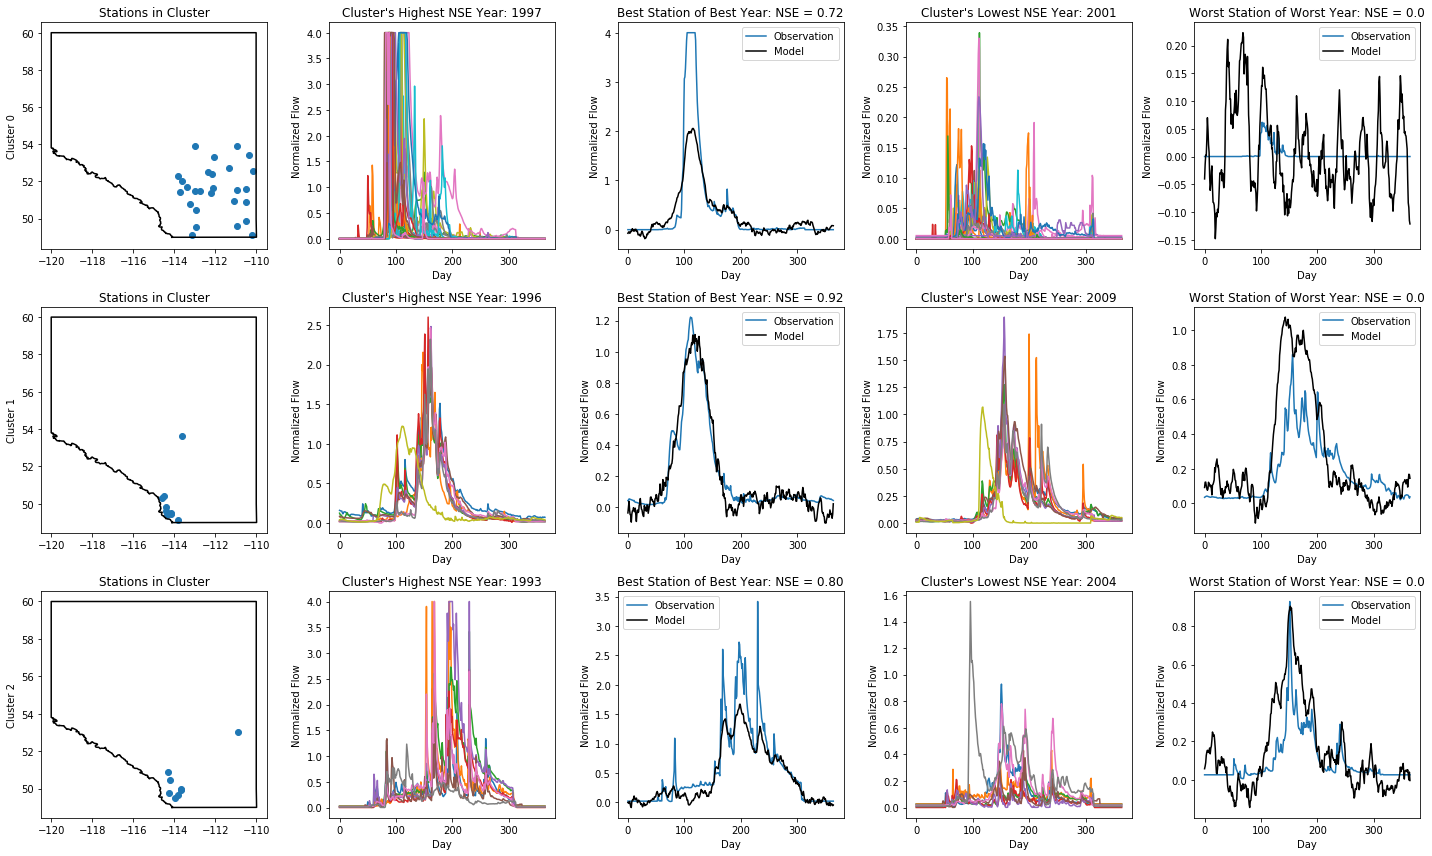

In [71]:
#what are the characteristics of the years with the highest and lowest NSE?

#make plot: rows are clusters, columns are 'best performing years' and 'worst performing years'

years = range(1988,2011)
n_cols = 5
plt.figure(figsize = (n_cols*4, n_clusters*4))

for cluster in range(n_clusters): #for each cluster

  #identify indices of rivers in this cluster
  stations_in_cluster = np.squeeze(stationInds[np.argwhere(labels==cluster)])
  if np.size(stations_in_cluster)==1: #if only one station, expand dimensions so array has a length of 1 so we can index the array
    stations_in_cluster = np.expand_dims(stations_in_cluster, axis = 0)
  stations_in_cluster_inds = np.reshape([np.argwhere(stationInds == stations_in_cluster[kk]) for kk in range(len(stations_in_cluster))],(-1,))

  #identify best and worst years/stations
  best_year = np.argmax(cluster_pattern[cluster])
  worst_year = np.argmin(cluster_pattern[cluster])
  NSE_stations_in_cluster = NSE_rolling_station[:,stations_in_cluster_inds]
  NSE_stations_best_year = NSE_stations_in_cluster[best_year,:]
  NSE_stations_worst_year = NSE_stations_in_cluster[worst_year,:]
  best_station_ind = stations_in_cluster_inds[np.argmax(NSE_stations_best_year)]
  worst_station_ind = stations_in_cluster_inds[np.argmin(NSE_stations_worst_year)]

  #plot stations in this cluster
  plt.subplot(n_clusters, n_cols, cluster*n_cols + 1)
  plot_AB()
  plt.scatter(stationLon[stations_in_cluster], stationLat[stations_in_cluster])
  plt.ylabel('Cluster ' + str(cluster))
  plt.title('Stations in Cluster')

  #plot all cluster members' flow during this best year
  plt.subplot(n_clusters, n_cols, cluster*n_cols + 2)
  for kk in stations_in_cluster_inds: #for each stream gauge in cluster
    start_ind = best_year*365
    final_ind = start_ind + 365
    plt.plot(y[start_ind:final_ind,kk])
    plt.xlabel('Day')
    plt.ylabel('Normalized Flow')
    plt.title('Cluster\'s Highest NSE Year: ' + str(years[best_year]))

  #plot the best performing cluster member in this best year, and it's modelled output
  plt.subplot(n_clusters, n_cols, cluster*n_cols + 3)
  start_ind = best_year*365
  final_ind = start_ind + 365
  plt.plot(y[start_ind:final_ind,best_station_ind], label = 'Observation')
  plt.plot(y_predicted[start_ind:final_ind,best_station_ind], color = 'k', label = 'Model')
  plt.xlabel('Day')
  plt.ylabel('Normalized Flow')
  plt.title('Best Station of Best Year: NSE = ' + str(NSE_rolling_station[best_year, best_station_ind])[:4])
  plt.legend()

  #plot all cluster members' flow during this worst year
  plt.subplot(n_clusters, n_cols, cluster*n_cols + 4)
  for kk in stations_in_cluster_inds: #for each stream gauge in cluster
    start_ind = worst_year*365
    final_ind = start_ind + 365
    plt.plot(y[start_ind:final_ind,kk])
    plt.xlabel('Day')
    plt.ylabel('Normalized Flow')
    plt.title('Cluster\'s Lowest NSE Year: ' + str(years[worst_year]))

  #plot the worst performing cluster member in this worst year, and it's modelled output
  plt.subplot(n_clusters, n_cols, cluster*n_cols + 5)
  start_ind = worst_year*365
  final_ind = start_ind + 365
  plt.plot(y[start_ind:final_ind,worst_station_ind], label = 'Observation')
  plt.plot(y_predicted[start_ind:final_ind, worst_station_ind], color = 'k', label = 'Model')
  plt.xlabel('Day')
  plt.ylabel('Normalized Flow')
  plt.title('Worst Station of Worst Year: NSE = ' + str(NSE_rolling_station[worst_year, worst_station_ind])[:4])
  plt.legend()

  plt.tight_layout()

plt.show()



# What is the model learning?

In [39]:
del x_train, history#, tempDict, precDict, flowDict, ssrdDict, spchDict

NameError: ignored

In [40]:
del Tnorm, Tmaxnorm, Tminnorm, Pnorm, Hnorm, Snorm, x_lat_norm, x_lon_norm

NameError: ignored

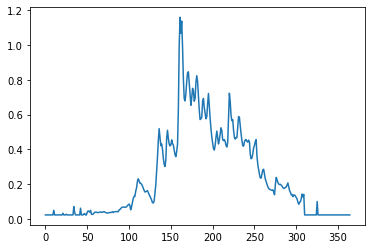

In [52]:
plt.plot(y[:365,station])

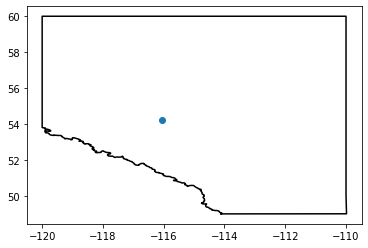

In [46]:
station = 8
plot_AB()
plt.scatter(stationLon[stationInds[station]], stationLat[stationInds[station]])

In [132]:
from scipy import interpolate

iters_total = 50
iters_one_pass = 50
days = range(170,171) #number of days to perturb
#day = 160 #day we're looking into
station = 8 #station we're looking into
p_1 = 0.9 #probability of 1 in mask
perturb_single_channel = True #if true, only perturb one of the channels to see what it's looking at
channel_perturb = 4 #if perturb_single_channel is True, this is the channel to be perturbing

h = 4
w = 4
H = np.shape(x_test)[2]
W = np.shape(x_test)[3]

heat_all_slices = []
heat_days = []
jj = 0

start = time.process_time()

for day in days:

  print('Day ' + str(day) + '/' + str(days[-1]))

  for kk in range(int(iters_total/iters_one_pass)):

    print('   Iteration: ' + str(kk*iters_one_pass) + '/' + str(iters_total))

    now = time.process_time() - start
    print('1: ' + str(now)[:6])

    iters = iters_one_pass

    x_int = np.arange(0,W+0.1,np.round(W/w))
    y_int = np.arange(0,H+0.1,np.round(H/h))
    xnew = np.arange(0,W,1)
    ynew = np.arange(0,H,1)

    now = time.process_time() - start
    print('2: ' + str(now)[:6])

    mask_small = np.random.choice([0,1],size = (iters,1,h+1,w+1), p = [1-p_1,p_1])
    mask_large = [interpolate.interp2d(x_int,y_int,mask_small[iter][0])(xnew,ynew) for iter in range(iters)]
    mask_large_2D = np.copy(mask_large)
    mask_large = np.repeat(np.expand_dims(np.asarray(mask_large),3),nchannels, axis = 3)
    mask_large = np.repeat(np.expand_dims(np.asarray(mask_large),1),365, axis = 1)

    now = time.process_time() - start
    print('3: ' + str(now)[:6])

    if perturb_single_channel is True:
      for channel in range(nchannels):
        if channel != channel_perturb:
          mask_large[:,:,:,:,channel] = 1

    now = time.process_time() - start
    print('4: ' + str(now)[:6])

    #day_slice = [day]
    xday = x_test[day]

    print('5a: ' + str(now)[:6])

    xday_iters = [np.repeat(xday,iters,axis=0) for day in range(len(day_slice))] #dimension: [days, iterations*365, lat, lon, channels]
    #xday_iters = [np.repeat(xday,iters,axis=0)]
    print(np.shape(xday_iters))
    xday_iters = np.reshape(xday_iters, (len(day_slice)*iters, 365, ) + np.shape(T[0]) + (nchannels,)) #dimension: [days*iterations*365, lat, lon, channels]; for passing through model
    print(np.shape(xday_iters))
    print('5b: ' + str(now)[:6])
    xday_iters_mask = [xday_iters[jj:jj+iters] * mask_large for jj in np.arange(0,len(day_slice)*iters,iters)]
    print(np.shape(xday_iters_mask))
    print('5c: ' + str(now)[:6])
    xday_iters_mask = np.reshape(xday_iters_mask,(len(day_slice) * iters, 365) + np.shape(T[0]) + (nchannels,))
    #xday_iters_mask = np.squeeze(xday_iters_mask)

    now = time.process_time() - start
    print('5: ' + str(now)[:6])

    x_all = np.squeeze(np.concatenate((np.expand_dims(xday, axis = 0),xday_iters_mask)))
    y_all = model.predict(x_all, batch_size = 128)

    now = time.process_time() - start
    print('6: ' + str(now)[:6])

    yday = y_all[:len(day_slice)]
    yday_mask = y_all[len(day_slice):]

    yday_station = yday[:,station]
    yday_station_mask = yday_mask[:,station]

    ydiffs = np.abs(np.reshape([yday_station[jj] - yday_station_mask[jj*iters:jj*iters + iters] for jj in range(len(day_slice))],(-1,1)))
    delta = np.ones((len(ydiffs),H,W)) * ydiffs[:,None]
    heat_iters = [np.asarray(delta[jj*iters:(jj+1)*iters]) * (1 - np.asarray(mask_large_2D)) for jj in range(len(day_slice))]
    heat_iters = np.reshape(heat_iters,(len(day_slice)*iters,H,W))
    heat = [np.mean(heat_iters[jj*iters : (jj+1)*iters], axis=0) for jj in range(len(day_slice))] #fast
    #heat = [np.transpose(heat[kk]) for kk in range(len(day_slice))] #fast
    heat_all_slices.append(heat[0]) #fast

    del heat, heat_iters, delta, ydiffs, x_all, xday_iters_mask, xday_iters

  heat_days.append(np.mean(heat_all_slices[jj : jj + int(iters_total/iters_one_pass)], axis = 0))
  jj += int(iters_total/iters_one_pass)

heat_mean = np.mean(heat_all_slices,axis=0)
heat_max = [np.max(heat_days[kk]) for kk in range(len(days))]

Day 170/170
   Iteration: 0/50
1: 0.0013
2: 0.0018
3: 0.0461
4: 0.1713
5a: 0.1713
(1, 18250, 18, 24, 5)
(50, 365, 18, 24, 5)
5b: 0.1713


NameError: ignored

In [130]:
# EDIT THIS ONE

iters_total = 500
iters_one_pass = 500
days = range(120,240) #number of days to perturb
#day = 160 #day we're looking into
station = 8 #station we're looking into
p_1 = 0.9 #probability of 1 in mask
perturb_single_channel = True #if true, only perturb one of the channels to see what it's looking at
channel_perturb = 0 #if perturb_single_channel is True, this is the channel to be perturbing

h = 4
w = 4
H = np.shape(x_test)[2]
W = np.shape(x_test)[3]

heat_all_slices = []
heat_days = []
jj = 0

start = time.process_time()

for day in days:

  print('Day ' + str(day) + '/' + str(days[-1]))

  for kk in range(int(iters_total/iters_one_pass)):

    print('   Iteration: ' + str(kk*iters_one_pass) + '/' + str(iters_total))

    now = time.process_time() - start
    print('1: ' + str(now)[:6])

    iters = iters_one_pass

    x_int = np.arange(0,W+0.1,np.round(W/w))
    y_int = np.arange(0,H+0.1,np.round(H/h))
    xnew = np.arange(0,W,1)
    ynew = np.arange(0,H,1)

    now = time.process_time() - start
    print('2: ' + str(now)[:6])

    mask_small = np.random.choice([0,1],size = (iters,1,h+1,w+1), p = [1-p_1,p_1])
    mask_large = np.half([interpolate.interp2d(x_int,y_int,mask_small[iter][0])(xnew,ynew) for iter in range(iters)])
    mask_large_2D = np.copy(mask_large)
    mask_large = np.repeat(np.expand_dims(np.asarray(mask_large),3),nchannels, axis = 3)
    mask_large = np.repeat(np.expand_dims(np.asarray(mask_large),1),365, axis = 1)

    now = time.process_time() - start
    print('3: ' + str(now)[:6])

    if perturb_single_channel is True:
      for channel in range(nchannels):
        if channel != channel_perturb:
          mask_large[:,:,:,:,channel] = 1

    now = time.process_time() - start
    print('4: ' + str(now)[:6])

    day_slice = [day]
    xday = x_test[day]

    now = time.process_time() - start
    print('5a: ' + str(now)[:6])

    #xday_iters = [np.repeat(xday,iters,axis=0) for day in range(len(day_slice))] #dimension: [days, iterations*365, lat, lon, channels]
    xday_iters = [np.repeat(xday,iters,axis=0)]
    print(np.shape(xday_iters))
    xday_iters = np.reshape(xday_iters, (iters, 365, ) + np.shape(T[0]) + (nchannels,)) #dimension: [days*iterations*365, lat, lon, channels]; for passing through model
    print(np.shape(xday_iters))

    now = time.process_time() - start
    print('5b: ' + str(now)[:6])

    #xday_iters_mask = [xday_iters[jj:jj+iters] * mask_large for jj in np.arange(0,len(day_slice)*iters,iters)]
    if perturb_single_channel is True:
      xday_iters_mask = xday_iters
      xday_iters_mask[:,:,:,:,channel_perturb] = np.multiply(xday_iters[:,:,:,:,channel_perturb],mask_large[:,:,:,:,channel_perturb])
    else: 
      xday_iters_mask = np.multiply(xday_iters,mask_large)
    #print(np.shape(xday_iters_mask))

    now = time.process_time() - start
    print('5c: ' + str(now)[:6])

    #xday_iters_mask = np.reshape(xday_iters_mask,(iters, 365) + np.shape(T[0]) + (nchannels,))
    #xday_iters_mask = np.squeeze(xday_iters_mask)
    #print(np.shape(xday_iters_mask))

    now = time.process_time() - start
    print('5: ' + str(now)[:6])

    x_all = np.squeeze(np.concatenate((np.expand_dims(xday, axis = 0),xday_iters_mask)))
    #print(np.shape(x_all))
    y_all = model.predict(x_all, batch_size = 128)

    now = time.process_time() - start
    print('6: ' + str(now)[:6])

    yday = y_all[:len(day_slice)]
    yday_mask = y_all[len(day_slice):]

    yday_station = yday[:,station]
    yday_station_mask = yday_mask[:,station]

    ydiffs = np.abs(np.reshape([yday_station[jj] - yday_station_mask[jj*iters:jj*iters + iters] for jj in range(len(day_slice))],(-1,1)))
    delta = np.ones((len(ydiffs),H,W)) * ydiffs[:,None]
    heat_iters = [np.asarray(delta[jj*iters:(jj+1)*iters]) * (1 - np.asarray(mask_large_2D)) for jj in range(len(day_slice))]
    heat_iters = np.reshape(heat_iters,(len(day_slice)*iters,H,W))
    heat = [np.mean(heat_iters[jj*iters : (jj+1)*iters], axis=0) for jj in range(len(day_slice))] #fast
    #heat = [np.transpose(heat[kk]) for kk in range(len(day_slice))] #fast
    heat_all_slices.append(heat[0]) #fast
    print(np.shape(heat_iters))

    del heat, heat_iters, delta, ydiffs, x_all, xday_iters_mask, xday_iters

  heat_days.append(np.mean(heat_all_slices[jj : jj + int(iters_total/iters_one_pass)], axis = 0))
  jj += int(iters_total/iters_one_pass)

heat_mean = np.mean(heat_all_slices,axis=0)
heat_max = [np.max(heat_days[kk]) for kk in range(len(days))]

now = time.process_time() - start
print(str(now)[:6])

Day 120/239
   Iteration: 0/500
1: 0.0010
2: 0.0013
3: 0.1515
4: 0.4619
5a: 0.4621
(1, 182500, 18, 24, 5)
(500, 365, 18, 24, 5)
5b: 0.9275
5c: 2.1492
5: 2.1494
6: 3.2139
(500, 18, 24)
Day 121/239
   Iteration: 0/500
1: 3.2213
2: 3.2214
3: 3.3750
4: 3.6905
5a: 3.6906
(1, 182500, 18, 24, 5)
(500, 365, 18, 24, 5)
5b: 4.0916
5c: 5.4246
5: 5.4248
6: 6.4823
(500, 18, 24)
Day 122/239
   Iteration: 0/500
1: 6.4893
2: 6.4895
3: 6.6389
4: 6.9552
5a: 6.9553
(1, 182500, 18, 24, 5)
(500, 365, 18, 24, 5)
5b: 7.4022
5c: 8.7227
5: 8.7228
6: 9.7690
(500, 18, 24)
Day 123/239
   Iteration: 0/500
1: 9.7763
2: 9.7765
3: 9.9351
4: 10.253
5a: 10.253
(1, 182500, 18, 24, 5)
(500, 365, 18, 24, 5)
5b: 10.656
5c: 11.895
5: 11.896
6: 12.899
(500, 18, 24)
Day 124/239
   Iteration: 0/500
1: 12.906
2: 12.906
3: 13.056
4: 13.374
5a: 13.374
(1, 182500, 18, 24, 5)
(500, 365, 18, 24, 5)
5b: 13.829
5c: 15.073
5: 15.073
6: 16.128
(500, 18, 24)
Day 125/239
   Iteration: 0/500
1: 16.135
2: 16.135
3: 16.287
4: 16.598
5a: 16.5

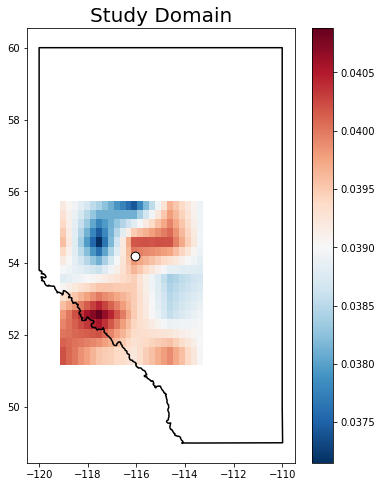

In [132]:
#visualize: where is the model most sensitive on average?

plt.figure(figsize = (6,8))
plot_AB()
plt.imshow(heat_mean,aspect='auto', cmap = 'RdBu_r',extent = extentERA)
plt.colorbar()
plt.scatter(stationLon[stationInds[station]],stationLat[stationInds[station]], facecolor = 'w', edgecolor = 'k', s = 75)
plt.title('Study Domain',fontsize = 20)

plt.show()

In [74]:
#visualize: where is the model sensitive each day?

plt.figure(figsize = (4*5,int(len(heat_days)/4)*5))

vmin = np.min(heat_days)
vmax = np.max(heat_days)

for kk in range(len(heat_days)):
  plt.subplot(int(len(heat_days)/4),4,kk+1)
  plt.imshow(heat_days[kk], aspect = 'auto', cmap = 'RdBu_r', extent = extentERA, vmin = vmin, vmax = vmax)
  plt.scatter(stationLon[stationInds[station]],stationLat[stationInds[station]], facecolor = 'w', edgecolor = 'k', s = 75)
  plot_AB()

KeyboardInterrupt: ignored

ValueError: ignored

<Figure size 1440x69120 with 110 Axes>

In [0]:
#cluster: what are the most characteristic "sensitivity days"?

data = np.asarray([np.squeeze(np.reshape(heat_day, (1,-1))) for heat_day in heat_days])
data_mean = data.mean(axis=1)
data_std = data.std(axis=1)
#data_norm = [(data[kk] - data_mean[kk]) / data_std[kk] for kk in range(len(data))]
data_norm = [data[kk] - data_mean[kk] for kk in range(len(data))]

n_clusters = 3
kmeans = KMeans(n_clusters = n_clusters).fit(data_norm)
labels = kmeans.labels_

#find mean pattern of each cluster
cluster_patterns = np.empty((n_clusters,np.shape(data)[1]))
for cluster_num in range(n_clusters):
    inds = np.argwhere(labels==cluster_num)
    cluster_patterns[cluster_num,:] = np.mean(data[inds,:],axis=0)
    
cluster_obs = np.empty((np.shape(data)))
for ind in range(len(data)):
    cluster_obs[ind] = cluster_patterns[labels[ind]]

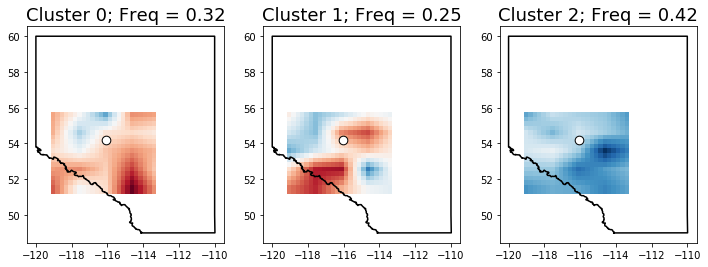

In [143]:
#visualize clusters

nrows = 1
ncols = n_clusters

vmin = np.min(cluster_patterns)
vmax = np.max(cluster_patterns)
plt.figure(figsize = (ncols*4,nrows*4))

for kk in range(n_clusters): #for each cluster
  cluster_pattern = cluster_patterns[kk,:]
  plt.subplot(nrows, ncols, kk+1)
  plt.imshow(np.reshape(cluster_pattern, np.shape(heat_days[0])), cmap = 'RdBu_r', vmin = vmin, vmax = vmax, extent = extentERA)
  plt.scatter(stationLon[stationInds[station]], stationLat[stationInds[station]], s = 75, facecolor = 'w', edgecolor = 'k')
  plot_AB()
  plt.title('Cluster ' + str(kk) + '; Freq = ' + str(len(np.argwhere(labels==kk)) / len(labels))[:4], fontsize = 18)

plt.show()

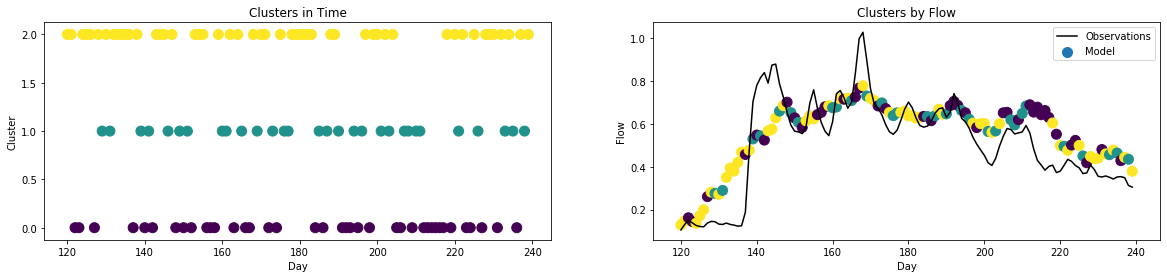

In [144]:
#visualize when clusters occur in time

plt.figure(figsize = (20,4))

plt.subplot(1,2,1)
plt.scatter(days, labels, c = labels, s = 100)
plt.xlabel('Day')
plt.ylabel('Cluster')
plt.title('Clusters in Time')

plt.subplot(1,2,2)
plt.plot(days, y_test[days,station],'k', label = 'Observations')
plt.scatter(days, y_test_predicted[days,station], c = labels, s = 100, label = 'Model')
plt.xlabel('Day')
plt.ylabel('Flow')
plt.title('Clusters by Flow')
plt.legend()

plt.show()

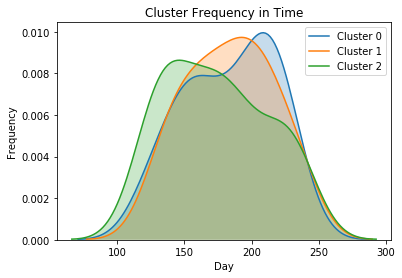

In [145]:
#visualize when clusters occur

for cluster in range(n_clusters):

  sns.kdeplot(data = [days[ind] for ind in np.argwhere(labels==cluster).ravel()], shade = True, label = 'Cluster '+str(cluster))

plt.legend()
plt.xlabel('Day')
plt.ylabel('Frequency')
plt.title('Cluster Frequency in Time')
plt.show()

In [0]:
#cluster again: what are the most characteristic "sensitivity days" of the sensitive clusters?

cluster_key = 0
cluster_key_inds = np.squeeze(np.argwhere(labels == cluster_key))

data = np.asarray([np.squeeze(np.reshape(heat_day, (1,-1))) for heat_day in heat_days])
data = data[cluster_key_inds,:]

data_mean = data.mean(axis=1)
data_std = data.std(axis=1)
#data_norm = [(data[kk] - data_mean[kk]) / data_std[kk] for kk in range(len(data))]
data_norm = [data[kk] - data_mean[kk] for kk in range(len(data))]

n_clusters = 5
kmeans = KMeans(n_clusters = n_clusters).fit(data)
labels2 = kmeans.labels_

#find mean pattern of each cluster
cluster_patterns = np.empty((n_clusters,np.shape(data)[1]))
for cluster_num in range(n_clusters):
    inds = np.argwhere(labels2==cluster_num)
    cluster_patterns[cluster_num,:] = np.mean(data[inds,:],axis=0)
    
cluster_obs = np.empty((np.shape(data)))
for ind in range(len(data)):
    cluster_obs[ind] = cluster_patterns[labels2[ind]]

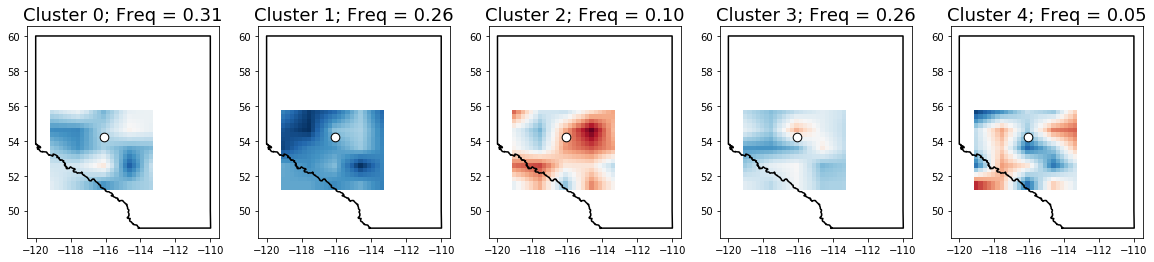

In [140]:
#visualize clusters

nrows = 1
ncols = n_clusters

vmin = np.min(cluster_patterns)
vmax = np.max(cluster_patterns)
plt.figure(figsize = (ncols*4,nrows*4))

for kk in range(n_clusters): #for each cluster
  cluster_pattern = cluster_patterns[kk,:]
  plt.subplot(nrows, ncols, kk+1)
  plt.imshow(np.reshape(cluster_pattern, np.shape(heat_days[0])), cmap = 'RdBu_r', vmin = vmin, vmax = vmax, extent = extentERA)
  plt.scatter(stationLon[stationInds[station]], stationLat[stationInds[station]], s = 75, facecolor = 'w', edgecolor = 'k')
  plot_AB()
  plt.title('Cluster ' + str(kk) + '; Freq = ' + str(len(np.argwhere(labels2==kk)) / len(labels2))[:4], fontsize = 18)

plt.show()

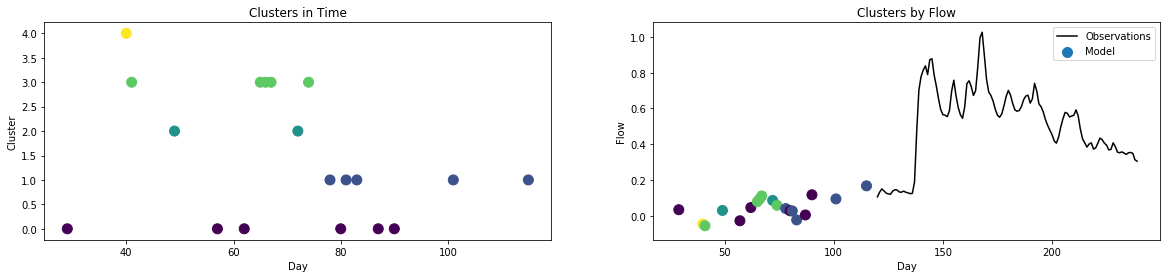

In [141]:
#visualize when clusters occur in time

plt.figure(figsize = (20,4))

plt.subplot(1,2,1)
plt.scatter(cluster_key_inds, labels2, c = labels2, s = 100)
plt.xlabel('Day')
plt.ylabel('Cluster')
plt.title('Clusters in Time')

plt.subplot(1,2,2)
plt.plot(days, y_test[days,station],'k', label = 'Observations')
plt.scatter(cluster_key_inds, y_test_predicted[cluster_key_inds,station], c = labels2, s = 100, label = 'Model')
plt.xlabel('Day')
plt.ylabel('Flow')
plt.title('Clusters by Flow')
plt.legend()

plt.show()

In [118]:
cluster_key_inds

array([ 0,  1,  6,  8, 10, 11, 27, 28, 45, 52, 53, 57, 59, 60, 61, 62, 66,
       67, 78, 96])

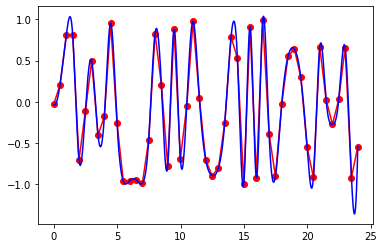

In [112]:
x = np.arange(-.01, 24.01, 0.5)
y = np.arange(-5.01, 5.01, 0.25)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx**2+yy**2)
f = interpolate.interp2d(x, y, z, kind='cubic')

xnew = np.arange(-.01, 24.01, 2e-2)
ynew = np.arange(-5.01, 5.01, 1e-2)
znew = f(xnew, ynew)
plt.plot(x, z[0, :], 'ro-', xnew, znew[0, :], 'b-')
plt.show()

In [113]:
np.shape(x), np.shape(y), np.shape(z)

((49,), (41,), (41, 49))

In [114]:
np.shape(xnew), np.shape(ynew), np.shape(znew)

((1202,), (1002,), (1002, 1202))

In [115]:
np.shape(x_int), np.shape(y_int), np.shape(mask_small[0][0])

((5,), (4,), (3, 4))

In [116]:
np.shape(xnew), np.shape(ynew), np.shape(mask_small[0][0])

((1202,), (1002,), (3, 4))

# Fine tune on one station

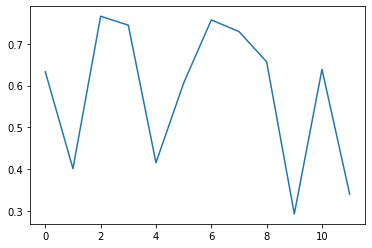

In [63]:
plt.plot(NSE_mean_stations_test)

In [0]:
#create input/output datasets

station_fine_tune = 0

#x is the same
y_fine_tune = y[:,station_fine_tune]
y_train_fine_tune = y_train[:,station_fine_tune]
y_test_fine_tune = y_test[:,station_fine_tune]

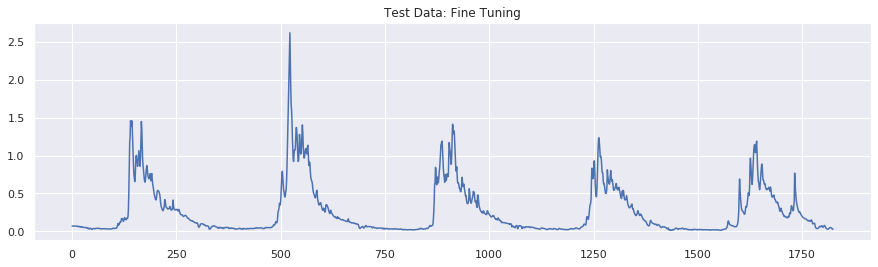

In [138]:
#visualize test data

plt.figure(figsize=(15,4))
plt.plot(y_test_fine_tune)
plt.title('Test Data: Fine Tuning')
plt.show()

In [0]:
#load model

loadModel = 0

if loadModel == 1:
  model = load_model('39_stations_LSTM_DO_LSTM_DENSE_20_epochs.h5')

In [150]:
#remove dense layer and add single connection

model_fine_tune = tensorflow.keras.models.clone_model(model_bulk)

#store the post-LSTM layers
#FC= model_fine_tune.layers[-1]

#remove post-LSTM layers from model
#model_fine_tune.pop() #remove Dense
model_fine_tune.add(Dense(1, activation = 'linear'))

model_fine_tune.compile(loss=tensorflow.keras.losses.MSE,
            optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate/2))

model_fine_tune.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_7 (TimeDist (None, 365, 18, 24, 8)    368       
_________________________________________________________________
time_distributed_8 (TimeDist (None, 365, 18, 24, 8)    584       
_________________________________________________________________
time_distributed_9 (TimeDist (None, 365, 9, 12, 8)     0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 365, 9, 12, 16)    528       
_________________________________________________________________
time_distributed_11 (TimeDis (None, 365, 9, 12, 16)    1040      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 365, 4, 6, 16)     0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 365, 384)         

In [151]:
#train model

trainModel = 1

if trainModel == 1:

  es = EarlyStopping(monitor='val_loss', 
                    mode='min', 
                    verbose=1, 
                    patience = 3)

  batch_size = 128
  epochs = 40
  history = model_fine_tune.fit(x_train,y_train_fine_tune, 
                      validation_split = 0.2, 
                      epochs = epochs, 
                      batch_size = batch_size,
                      verbose = 1, 
                      callbacks = [es])

Train on 5260 samples, validate on 1315 samples
Epoch 1/40
5260/5260 [==============================] - 16s 3ms/sample - loss: 0.1005 - val_loss: 0.0405
Epoch 2/40
5260/5260 [==============================] - 14s 3ms/sample - loss: 0.0610 - val_loss: 0.0365
Epoch 3/40
5260/5260 [==============================] - 14s 3ms/sample - loss: 0.0533 - val_loss: 0.0350
Epoch 4/40
5260/5260 [==============================] - 14s 3ms/sample - loss: 0.0411 - val_loss: 0.0321
Epoch 5/40
5260/5260 [==============================] - 14s 3ms/sample - loss: 0.0369 - val_loss: 0.0309
Epoch 6/40
5260/5260 [==============================] - 14s 3ms/sample - loss: 0.0334 - val_loss: 0.0305
Epoch 7/40
5260/5260 [==============================] - 14s 3ms/sample - loss: 0.0299 - val_loss: 0.0297
Epoch 8/40
5260/5260 [==============================] - 14s 3ms/sample - loss: 0.0280 - val_loss: 0.0296
Epoch 9/40
5260/5260 [==============================] - 14s 3ms/sample - loss: 0.0254 - val_loss: 0.0287
Epoch 1

In [0]:
#save model

saveModel = 0

if saveModel == 1:

  if glacierStations == 1:
    modelName = str(num_stations) + '_stations_' + 'LSTM_DO_LSTM_DENSE_glacierStations_' + str(epochs) + '_epochs_fine_tune'
    model.save(modelName + '.h5')
  else:
    modelName = str(num_stations) + '_stations_' + 'LSTM_DO_LSTM_DENSE_' + str(epochs) + '_epochs_fine_tune'
    model.save(modelName + '.h5')

In [0]:
#load model

loadModel = 0

if loadModel == 1:

  dataPath = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/'

  if glacierStations == 1:
    #modelName = str(num_stations) + '_stations_' + 'LSTM_DO_LSTM_DENSE_glacierStations_' + str(epochs) + '_epochs_fine_tune'
    modelName = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/18_stations_LSTM_DO_LSTM_DENSE_glacierStations_20_epochs_fine_tune'
    #model = load_model(dataPath + modelName + '.h5')
    model = load_model(modelName + '.h5')
  else:
    modelName = str(num_stations) + '_stations_' + 'LSTM_DO_LSTM_DENSE'
    model = load_model(dataPath + modelName + '.h5')

  #model = load_model(dataPath + str(num_stations) + '_stations_LSTM_DO_LSTM_DENSE.h5')

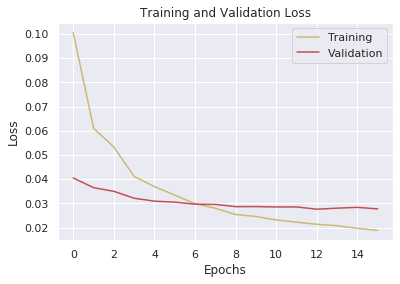

In [154]:
saveIt = 0

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(loss, 'y', label='Training')
plt.plot(val_loss, 'r', label='Validation')
plt.title('Training and Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.ylim((0,1))
#plt.show()

if saveIt:
  plt.savefig('loss.png')

In [155]:
#predict streamflow with trained model
#y_trainPredict = model.predict(x_train)
y_test_fine_tune_predict = model_fine_tune.predict(x_test, batch_size = batch_size, verbose = 1)

1825/1825 [==============================] - 2s 1ms/sample


In [156]:
RMSE_bulk = rmse(target = y_test[:,station_fine_tune], prediction = y_test_predicted[:,station_fine_tune])
RMSE_fine_tune = rmse(target = y_test_fine_tune, prediction = y_test_fine_tune_predict)

print('RMSE Bulk = ' + str(RMSE_bulk)[:4])
print('RMSE Fine = ' + str(RMSE_fine_tune)[:4])

RMSE Bulk = 0.15
RMSE Fine = 0.15


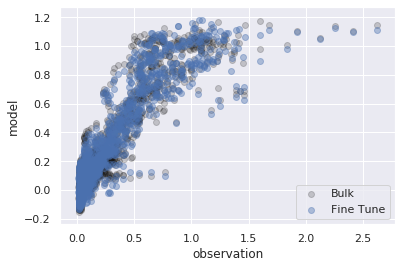

In [157]:
#visualize

saveIt = 0

plt.scatter(y_test[:,station_fine_tune],y_test_predicted[:,station_fine_tune],facecolor = 'k',alpha = 0.2)
plt.scatter(y_test_fine_tune,y_test_fine_tune_predict, alpha = 0.4, edgecolor = 'b')
plt.legend(('Bulk','Fine Tune'))
plt.xlabel('observation')
plt.ylabel('model')

if saveIt:
  plt.savefig('obs_vs_model.png')

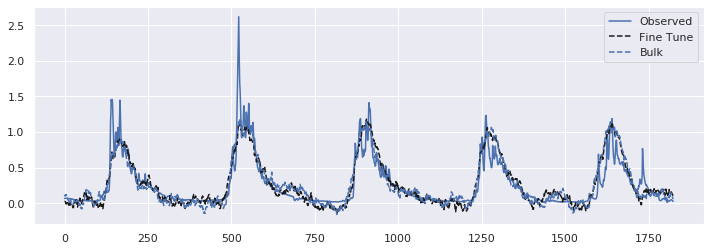

In [158]:
plt.figure(figsize = (12,4))
plt.plot(y_test_fine_tune, label = 'Observed')
plt.plot(y_test_fine_tune_predict,'k--', label = 'Fine Tune')
plt.plot(y_test_predicted[:,station_fine_tune],'b--', label = 'Bulk')
plt.legend()

In [159]:
#compute NSE

window = 366
stride = 365
NSE = nse(y_test_fine_tune,y_test_fine_tune_predict)
NSE_rolling = nse_rolling(y_test_fine_tune, y_test_fine_tune_predict, window = window, stride = stride)
print('NSE = ' + str(NSE)[:4])

NSE = 0.79


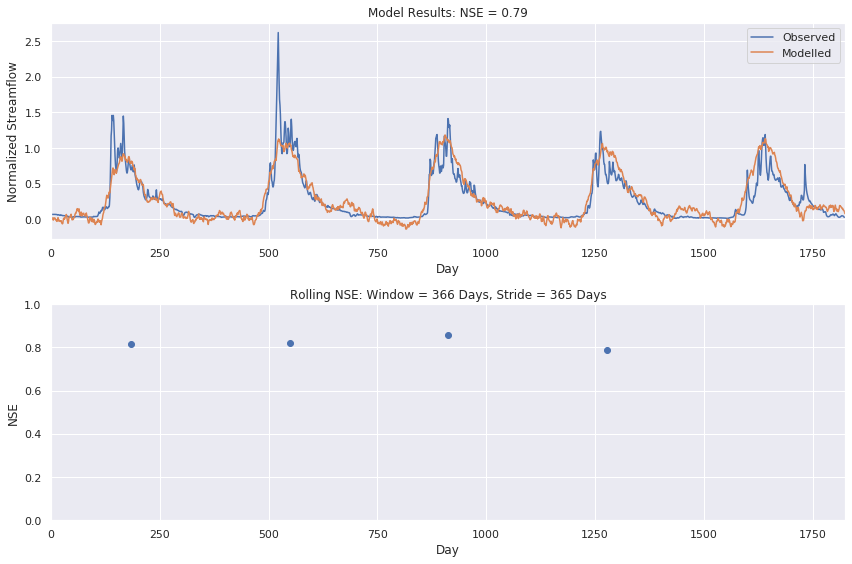

In [160]:
#visualize more

saveIt = 0

plt.figure(figsize = (12,8))

plt.subplot(2,1,1)
plt.plot(y_test_fine_tune, label = 'Observed')
plt.plot(y_test_fine_tune_predict, label = 'Modelled')
#plt.xlim((4500,6000))
plt.legend()
plt.xlabel('Day')
plt.ylabel('Normalized Streamflow')
plt.xlim((0,len(y_test_fine_tune)))
plt.title('Model Results: NSE = ' + str(NSE)[:4])

plt.subplot(2,1,2)
plt.scatter(range(int(window/2),len(y_test_fine_tune)-int(window/2), stride),NSE_rolling)
#plt.plot(NSE_rolling)
plt.ylim((0,1))
plt.xlim((0,len(y_test_fine_tune)))
plt.xlabel('Day')
plt.ylabel('NSE')
plt.title('Rolling NSE: Window = ' + str(window) + ' Days, Stride = ' + str(stride) + ' Days')

plt.tight_layout()

if saveIt:
  plt.savefig('modelled_time_series.png')

plt.show()

In [161]:
#compute NSE

num_stations = len(stationInds)

obs_per_station_test = int(len(y_test)/num_stations)
window = 366
NSE = nse(y_test,y_test_predicted)
NSE_rolling = nse_rolling(y_test, y_test_predicted, window, stride = 365)
NSE_station = [nse(y_test[kk*obs_per_station_test:(kk+1)*obs_per_station_test], y_test_predicted[kk*obs_per_station_test:(kk+1)*obs_per_station_test]) for kk in range(num_stations)]

print('Overall NSE = ' + str(NSE)[:4])
print('Mean Station NSE = ' + str(np.mean(NSE_station))[:4])
print('Median Station NSE = ' + str(np.median(NSE_station))[:4])

Overall NSE = 0.74
Mean Station NSE = -0.0
Median Station NSE = 0.57


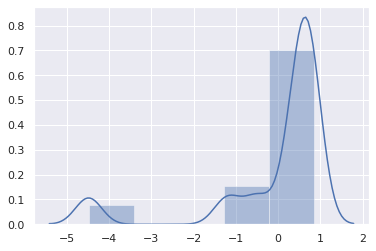

In [162]:
#visualize stations' performance

sns.set(color_codes=True)
sns.distplot(NSE_station, bins = 5)
plt.show()

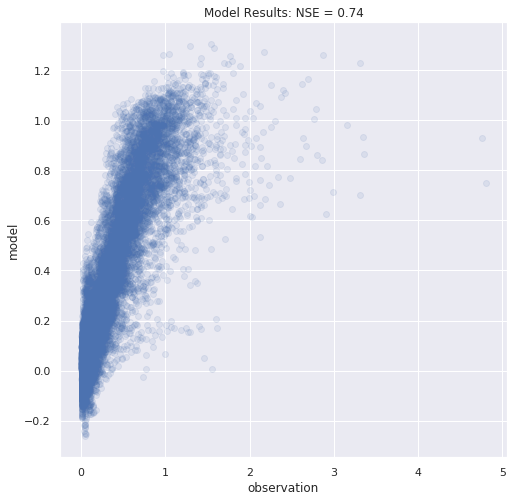

In [163]:
#plot model vs observed scatter plot

saveIt = 0

plt.figure(figsize = (8,8))

plt.scatter(y_test, y_test_predicted, alpha = 0.1)
plt.xlabel('observation')
plt.ylabel('model')
plt.title('Model Results: NSE = ' + str(NSE)[:4])
#plt.xlim((-2,5))
#plt.xlim((0,4))
#plt.yscale('log')
#plt.xscale('log')

if saveIt:
  plt.savefig('obs_vs_model.png')

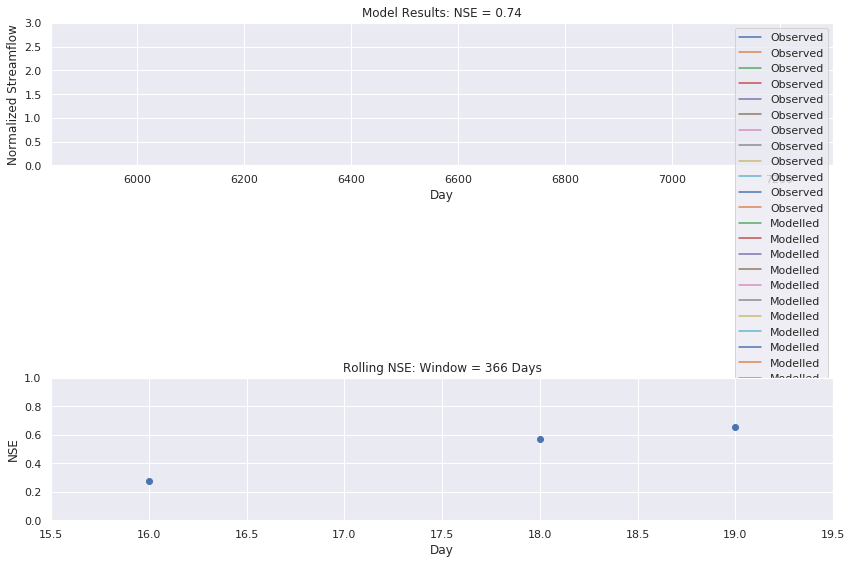

In [40]:
#plot time series of model and observations 

saveIt = 0

plt.figure(figsize = (12,8))
plt.subplot(2,1,1)
plt.plot(y_test, label = 'Observed')
plt.plot(y_testPredict, label = 'Modelled')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Normalized Streamflow')
plt.title('Model Results: NSE = ' + str(NSE)[:4])
plt.xlim((0,len(y_test)))
plt.xlim((4*365*4,4*365*5))
plt.ylim((0,3))

plt.subplot(2,1,2)
#plt.plot(range(int(window/2),len(y_test)-int(window/2)),NSE_rolling)
plt.scatter(range(len(NSE_rolling)),NSE_rolling)
plt.ylim((0,1))
plt.xlim((0,len(NSE_rolling)))
plt.xlim((15.5,19.5))
plt.xlabel('Day')
plt.ylabel('NSE')
plt.title('Rolling NSE: Window = ' + str(window) + ' Days')

plt.tight_layout()

if saveIt:
  plt.savefig('modelled_time_series.png')

plt.show()